# Forecast

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
import pyaiutils as pai
import tensorflow as tf
import pandas as pd
import numpy as np
import pathlib
import pickle
import shap

spark = SparkSession.builder \
    .master("local") \
    .appName("master-covid") \
    .getOrCreate()
spark.sparkContext.setLogLevel("FATAL")

22/07/11 23:35:26 WARN Utils: Your hostname, predator resolves to a loopback address: 127.0.1.1; using 192.168.15.48 instead (on interface wlp0s20f3)
22/07/11 23:35:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/11 23:35:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Variáveis

In [2]:
PATH_DATA = 'datas'
PATH_RESULT = 'results'

#### Funções

Função para exibir o o histórico de treinamento

- history: history de treinamento

In [3]:
def show_history(path: str, type: str = 'acc', limit: dict = None):
    """_summary_

    Parameters
    ----------
    path : str
        _description_
    type : str, optional
        acc or categorical_accuracy, by default 'acc'
    """
    with open(path, 'rb') as f:
        history = pickle.load(f)

    print(history.keys())

    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 7))

    ax[0].set_ylabel('Categorical Crossentropy')
    ax[0].plot(range(len(history['loss'])), history['loss'], label='Loss do treino', color='k', linewidth=1.2)
    ax[0].plot(range(len(history['loss'])), history['val_loss'], label='Loss da validação', color='k', linestyle='--', linewidth=1.2)
    ax[0].legend()
    if limit and limit.get(0):
        ax[0].set_xlim(limit[0].get('xlim'))
        ax[0].set_ylim(limit[0].get('ylim'))

    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Acurácia')
    ax[1].plot(range(len(history['loss'])), history[type], label='Acurácia do treino', color='k', linewidth=1.2)
    ax[1].plot(range(len(history['loss'])), history[f'val_{type}'], label='Acurácia da validação', color='k', linestyle='--', linewidth=1.2)
    ax[1].legend()
    if limit and limit.get(1):
        ax[1].set_xlim(limit[1].get('xlim'))
        ax[1].set_ylim(limit[1].get('ylim'))

    plt.show()

Metrics

In [4]:
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [5]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [6]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Função para avaliação do modelo
- model: modelo
- x_test: dataframe de entrada
- y_test: dataframe alvo
- class_names: classes
- path: caminho para armazenar os resultados

In [7]:
def evaluate(
    model: tf.keras.Sequential,
    x_test: np.ndarray,
    y_test: np.ndarray,
    class_names: list[str],
    path: str
) -> None:
    y_pred = model.predict(x_test)
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    pai.plot_graphics(y_true, y_pred, class_names=class_names, save_path=path)
    display(pai.get_metrics(y_true, y_pred, class_names=class_names, save_path=path))

## Classificação

Algoritmos de classificação

![title](https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png)

Métricas de avaliação

Matriz de Confusão | Recall vs Precision | Equação de 4 diferentes métricas
- | - | -
![](https://miro.medium.com/max/1400/1*N6I3pi0prhiJ_Y85HAx4wA.png) | ![](https://miro.medium.com/max/700/0*uhuG2rhX6XzNC43X.png) | ![](https://miro.medium.com/max/1400/1*UVP_xb4F6J-M-xH3haz5Jw.png)

### ÓBITO/CURA

Carregando dataframe:

|sintomas|comorbidades|sexo|desfecho|
|--|--|--|--|
|1. Sim|1. Sim|1: Masculino|0. Óbito|
|2. Não|2. Não|2: Feminino|1. Cura|
|9. Ignorado|9. Ignorado|9: Ignorado||
|0. NULL|0. NULL|||

In [8]:
df = spark.read.parquet(f'{PATH_DATA}/prepare/c1/3-enrich.parquet')
df.show()

+-------+-----+-----+--------+--------+--------+--------+---------+---------+------+-------+------+---------+---------+-----+
|CS_SEXO|FEBRE|TOSSE|DISPNEIA|GARGANTA|DIARREIA|EVOLUCAO|DESC_RESP|SATURACAO|VOMITO|DOR_ABD|FADIGA|PERD_OLFT|PERD_PALA|IDADE|
+-------+-----+-----+--------+--------+--------+--------+---------+---------+------+-------+------+---------+---------+-----+
|      1|    0|    1|       1|       0|       0|       0|        1|        0|     0|      0|     0|        0|        0|   76|
|      2|    1|    2|       2|       2|       2|       0|        1|        2|     2|      2|     2|        2|        2|   73|
|      1|    1|    1|       2|       2|       2|       0|        1|        1|     2|      2|     1|        2|        2|   89|
|      2|    0|    1|       1|       0|       0|       1|        0|        0|     0|      0|     0|        0|        0|   72|
|      2|    9|    1|       1|       9|       1|       1|        1|        1|     0|      1|     1|        9|        9

In [9]:
df.groupBy('EVOLUCAO').count().show()

+--------+-------+
|EVOLUCAO|  count|
+--------+-------+
|       1|1070198|
|       0| 571435|
+--------+-------+



Listando as colunas existentes

In [10]:
df.columns

['CS_SEXO',
 'FEBRE',
 'TOSSE',
 'DISPNEIA',
 'GARGANTA',
 'DIARREIA',
 'EVOLUCAO',
 'DESC_RESP',
 'SATURACAO',
 'VOMITO',
 'DOR_ABD',
 'FADIGA',
 'PERD_OLFT',
 'PERD_PALA',
 'IDADE']

Delimitando as colunas de interesse

In [13]:
symptoms = [
    'FEBRE',
    'TOSSE',
    'DISPNEIA',
    'GARGANTA',
    'DIARREIA',
    'DESC_RESP',
    'SATURACAO',
    'VOMITO',
    'DOR_ABD',
    'FADIGA',
    'PERD_OLFT',
    'PERD_PALA',
]
comorbidities = [
]

Colunas para estudo

In [14]:
x_cols = [
    *symptoms,
    # *comorbidities,
    'IDADE',
    'CS_SEXO',
]
y_cols = ['EVOLUCAO']

Split dataset
- train 60
- test 20
- val 20

In [15]:
x_train, x_val, y_train, y_val = train_test_split(
    df.select(x_cols).collect(),
    df.select(y_cols).collect(),
    test_size=0.2,
    random_state=1
)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    x_train,
    y_train,
    test_size=0.25,
    random_state=1
)

Normalizando os dados de entrada

In [17]:
x_scaler = MinMaxScaler((0,1))

x_train = x_scaler.fit_transform(x_train)
x_val = x_scaler.transform(x_val)
x_test = x_scaler.transform(x_test)

In [18]:
scalers = f'{PATH_RESULT}/scalers/c1'
pathlib.Path(scalers).mkdir(parents=True, exist_ok=True)

In [19]:
pickle.dump(x_scaler, open(f'{scalers}/xscaler.pkl', 'wb'))

In [20]:
prepared_data = f'{PATH_DATA}/prepare/c1'
pathlib.Path(prepared_data).mkdir(parents=True, exist_ok=True)

In [21]:
pd.DataFrame(x_train, columns=x_cols).to_csv(f'{prepared_data}/xtrain.csv.gz', compression='gzip', index=False)
pd.DataFrame(y_train, columns=y_cols).to_csv(f'{prepared_data}/ytrain.csv.gz', compression='gzip', index=False)
pd.DataFrame(x_val, columns=x_cols).to_csv(f'{prepared_data}/xval.csv.gz', compression='gzip', index=False)
pd.DataFrame(y_val, columns=y_cols).to_csv(f'{prepared_data}/yval.csv.gz', compression='gzip', index=False)
pd.DataFrame(x_test, columns=x_cols).to_csv(f'{prepared_data}/xtest.csv.gz', compression='gzip', index=False)
pd.DataFrame(y_test, columns=y_cols).to_csv(f'{prepared_data}/ytest.csv.gz', compression='gzip', index=False)

Conversão da saída para categorical (One Hot Encoding)

In [22]:
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [23]:
classes_target = ['Óbito', 'Cura']
pd.DataFrame(y_train, columns=classes_target).to_csv(f'{prepared_data}/ytrain_ohe.csv', compression='gzip', index=False)
pd.DataFrame(y_val, columns=classes_target).to_csv(f'{prepared_data}/yval_ohe.csv', compression='gzip', index=False)
pd.DataFrame(y_test, columns=classes_target).to_csv(f'{prepared_data}/ytest_ohe.csv', compression='gzip', index=False)

#### RNA (MLP)

In [24]:
model_mlp = f'{PATH_RESULT}/models/c1/mlp'
pathlib.Path(model_mlp).mkdir(parents=True, exist_ok=True)

otimizador

In [25]:
model_o = tf.keras.models.load_model(
    f'{model_mlp}/init_weights_nsgaii_best_model.h5',
    custom_objects = {
        'precision_m': precision_m,
        'recall_m': recall_m,
        'f1_m': f1_m
    }
)
model_o.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 22)]              0         
                                                                 
 dense_2 (Dense)             (None, 23)                529       
                                                                 
 dense_3 (Dense)             (None, 20)                480       
                                                                 
 dense_4 (Dense)             (None, 55)                1155      
                                                                 
 dense_5 (Dense)             (None, 81)                4536      
                                                                 
 dense_6 (Dense)             (None, 39)                3198      
                                                                 
 dense_7 (Dense)             (None, 37)                1480

2022-07-11 23:37:36.583757: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2022-07-11 23:37:36.583781: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: predator
2022-07-11 23:37:36.583787: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: predator
2022-07-11 23:37:36.583901: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.73.5
2022-07-11 23:37:36.583917: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-07-11 23:37:36.583922: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.48.7 does not match DSO version 510.73.5 -- cannot find working devices in this configuration
2022-07-11 23:37:36.584116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow

dict_keys(['val_loss', 'val_categorical_accuracy', 'val_precision_m', 'val_recall_m', 'val_f1_m', 'loss', 'categorical_accuracy', 'precision_m', 'recall_m', 'f1_m'])


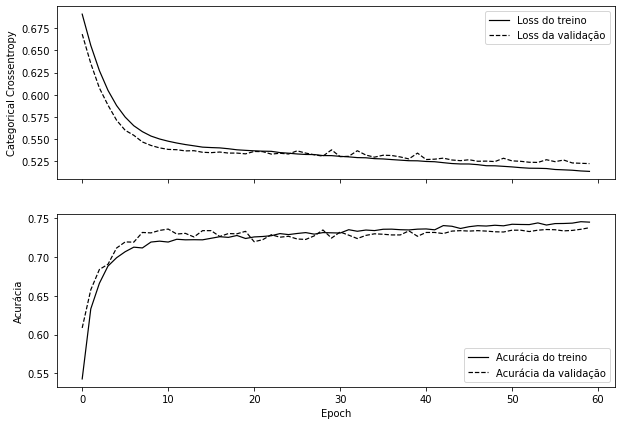

In [26]:
show_history(f'{model_mlp}/history_nsgaii_best_model.pk', 'categorical_accuracy')

---

In [27]:
model = tf.keras.models.load_model(
    f'{model_mlp}/best_model.h5',
    custom_objects = {
        'precision_m': precision_m,
        'recall_m': recall_m,
        'f1_m': f1_m
    }
)
model.summary()

Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 23)                322       
                                                                 
 dense_1 (Dense)             (None, 20)                480       
                                                                 
 dense_2 (Dense)             (None, 55)                1155      
                                                                 
 dense_3 (Dense)             (None, 81)                4536      
                                                                 
 dense_4 (Dense)             (None, 39)                3198      
                                                                 
 dense_5 (Dense)             (None, 37)                1480      
                                                                 
 dense_6 (Dense)             (None, 86)                3268    

In [28]:
def mlp_model(input_shape: tuple) -> tf.keras.Model:
    tf.keras.backend.clear_session()

    opt = tf.keras.optimizers.Adagrad(learning_rate=0.030188940634207535)
    auc = tf.keras.metrics.AUC()

    model = tf.keras.models.Sequential(name='mlp')
    model.add(tf.keras.layers.Input(shape=input_shape))
    model.add(tf.keras.layers.Dense(units=23, activation='softplus'))
    model.add(tf.keras.layers.Dense(units=20, activation='relu'))
    # model.add(tf.keras.layers.Dropout(rate=0.4))
    # model.add(tf.keras.layers.Dense(units=55, activation='elu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(tf.keras.layers.Dense(units=55, activation='elu'))
    model.add(tf.keras.layers.Dense(units=81, activation='softplus'))
    model.add(tf.keras.layers.Dense(units=39, activation='hard_sigmoid'))
    model.add(tf.keras.layers.Dense(units=37, activation='relu'))
    # model.add(tf.keras.layers.Dropout(rate=0.4))
    # model.add(tf.keras.layers.Dense(units=86, activation='elu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
    model.add(tf.keras.layers.Dense(units=86, activation='elu'))
    model.add(tf.keras.layers.Dense(units=2, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['acc', precision_m, recall_m, f1_m, auc]
    )
    return model

In [29]:
monitor = 'val_loss'
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=10, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(filepath=f'{model_mlp}/best_model.h5', monitor=monitor, save_best_only=True, mode='min'),
    tf.keras.callbacks.TensorBoard(log_dir=f'{model_mlp}/logs'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=7, min_delta=1e-4, mode='min'),
]

In [30]:
model = mlp_model((x_train.shape[1],))
# train the neural network
H = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,#72,
    batch_size=76,
    callbacks=callbacks
)

# Uncomment if you don't use callbacks
# model.save(f'{path_mlpcovid}/best_model.h5')

with open(f'{model_mlp}/history_best_model.pkl', 'wb') as f:
    pickle.dump(H.history, f)

Epoch 1/200
12961/12961 [==============================] - 24s 2ms/step - loss: 0.6073 - acc: 0.6759 - precision_m: 0.6759 - recall_m: 0.6759 - f1_m: 0.6759 - auc: 0.7291 - val_loss: 0.5836 - val_acc: 0.6912 - val_precision_m: 0.6912 - val_recall_m: 0.6912 - val_f1_m: 0.6912 - val_auc: 0.7606 - lr: 0.0302
Epoch 2/200
12961/12961 [==============================] - 23s 2ms/step - loss: 0.5819 - acc: 0.6929 - precision_m: 0.6929 - recall_m: 0.6929 - f1_m: 0.6929 - auc: 0.7615 - val_loss: 0.5810 - val_acc: 0.6923 - val_precision_m: 0.6924 - val_recall_m: 0.6924 - val_f1_m: 0.6924 - val_auc: 0.7623 - lr: 0.0302
Epoch 3/200
12961/12961 [==============================] - 23s 2ms/step - loss: 0.5813 - acc: 0.6933 - precision_m: 0.6933 - recall_m: 0.6933 - f1_m: 0.6933 - auc: 0.7621 - val_loss: 0.5819 - val_acc: 0.6913 - val_precision_m: 0.6913 - val_recall_m: 0.6913 - val_f1_m: 0.6913 - val_auc: 0.7613 - lr: 0.0302
Epoch 4/200
12961/12961 [==============================] - 23s 2ms/step - loss:

dict_keys(['loss', 'acc', 'precision_m', 'recall_m', 'f1_m', 'auc', 'val_loss', 'val_acc', 'val_precision_m', 'val_recall_m', 'val_f1_m', 'val_auc', 'lr'])


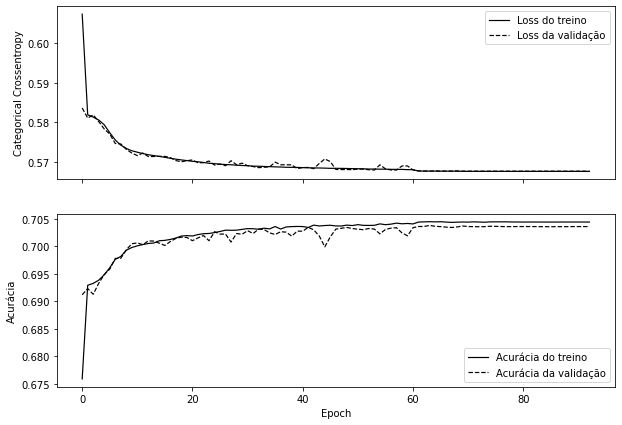

In [31]:
show_history(f'{model_mlp}/history_best_model.pkl')#, limit={1: {'ylim': (0.62, 0.655)}})

10261/10261 [==============================] - 8s 780us/step


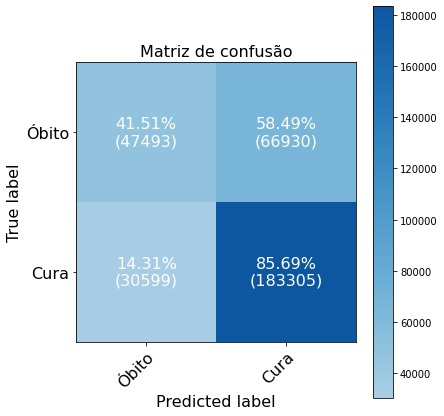

None

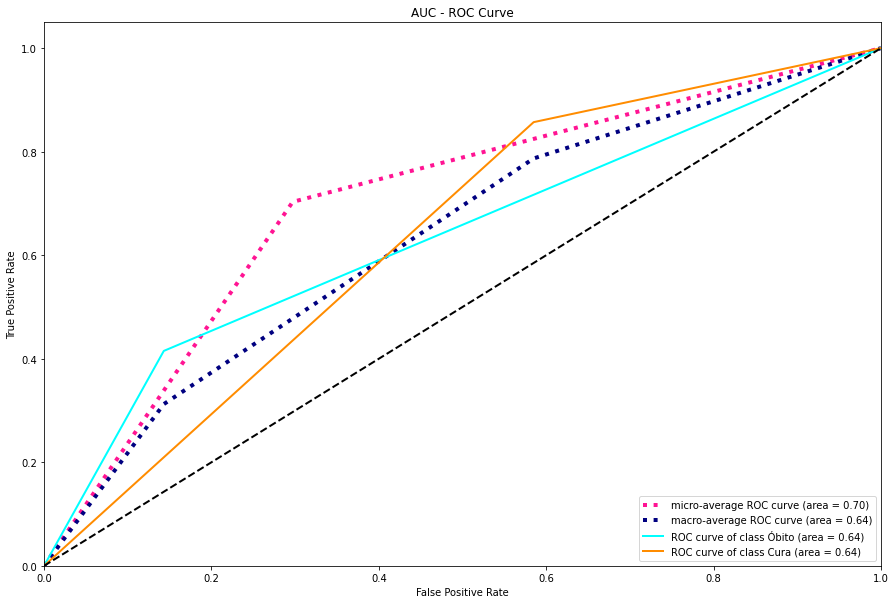

None

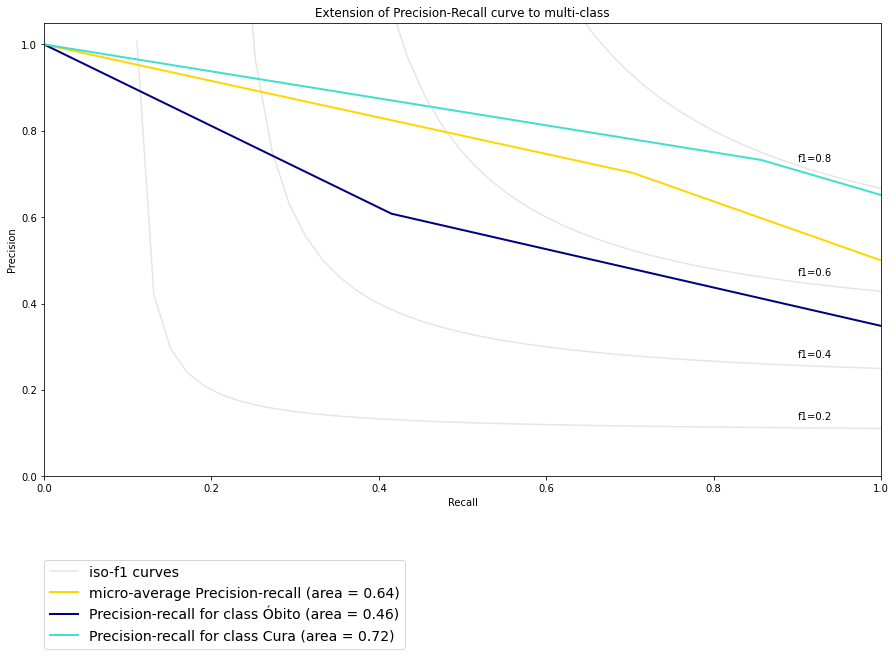

None

Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.49     0.64     0.46       0.61    0.42         0.86       0.7
1    Cura  0.79     0.64     0.72       0.73    0.86         0.42       0.7
2   Média  0.64     0.64     0.59       0.67    0.64         0.64       0.7

In [32]:
evaluate(
    model=model,
    x_test=x_test,
    y_test=y_test,
    class_names=['Óbito', 'Cura'],
    path=model_mlp
)

In [81]:
# background = x_train[np.random.choice(x_train.shape[0], size=100, replace=False)]
# # type(np.array(x_train[np.random.choice(x_train.shape[0], size=10000, replace=False)])
# # explainer = shap.GradientExplainer(model, pd.DataFrame(x_train)[:1000])
# explainer = shap.GradientExplainer(model, background)
# samples = x_test[np.random.choice(x_test.shape[0], 10, replace=False)]
# shap_values = explainer.shap_values(samples)
# # shap.summary_plot(shap_values, samples, feature_names=x_cols, class_names=['Outra-SRAG', 'Covid-19'], show=False)
# # plt.savefig(f'{model_mlp}/shap_summary.png')
# # plt.show()

In [51]:
# class_names = ['Outra-SRAG', 'Covid-19']
# for feat in x_cols:
#     for clss in range(len(class_names)):
#         shap.dependence_plot(
#             feat,
#             shap_values[clss],
#             samples,
#             interaction_index='idade',
#             alpha=0.5,
#             feature_names=x_cols,
#             show=False
#         )
#         plt.savefig(f'{model_mlp}/dependence/{class_names[clss]}_{feat}.png')

#### RNA (MLP) K-FOLD

In [33]:
mlp_kfold = f'{model_mlp}/kfold'
pathlib.Path(mlp_kfold).mkdir(parents=True, exist_ok=True)

Epoch 1/79
20521/20521 [==============================] - 30s 1ms/step - loss: 0.6053 - acc: 0.6764 - precision_m: 0.6765 - recall_m: 0.6765 - f1_m: 0.6765 - auc: 0.7317
Epoch 2/79
20521/20521 [==============================] - 30s 1ms/step - loss: 0.5815 - acc: 0.6923 - precision_m: 0.6924 - recall_m: 0.6924 - f1_m: 0.6924 - auc: 0.7618
Epoch 3/79
20521/20521 [==============================] - 30s 1ms/step - loss: 0.5806 - acc: 0.6932 - precision_m: 0.6932 - recall_m: 0.6932 - f1_m: 0.6932 - auc: 0.7627
Epoch 4/79
20521/20521 [==============================] - 30s 1ms/step - loss: 0.5786 - acc: 0.6947 - precision_m: 0.6947 - recall_m: 0.6947 - f1_m: 0.6947 - auc: 0.7647
Epoch 5/79
20521/20521 [==============================] - 30s 1ms/step - loss: 0.5750 - acc: 0.6980 - precision_m: 0.6980 - recall_m: 0.6980 - f1_m: 0.6980 - auc: 0.7683
Epoch 6/79
20521/20521 [==============================] - 30s 1ms/step - loss: 0.5730 - acc: 0.6997 - precision_m: 0.6997 - recall_m: 0.6997 - f1_m: 0

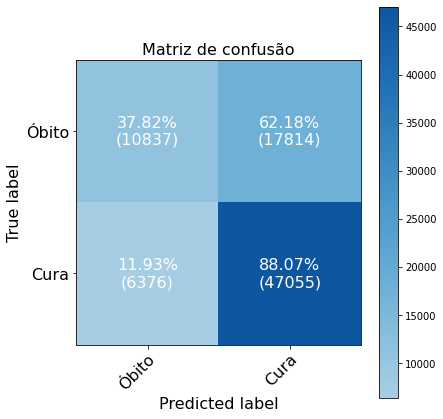

None

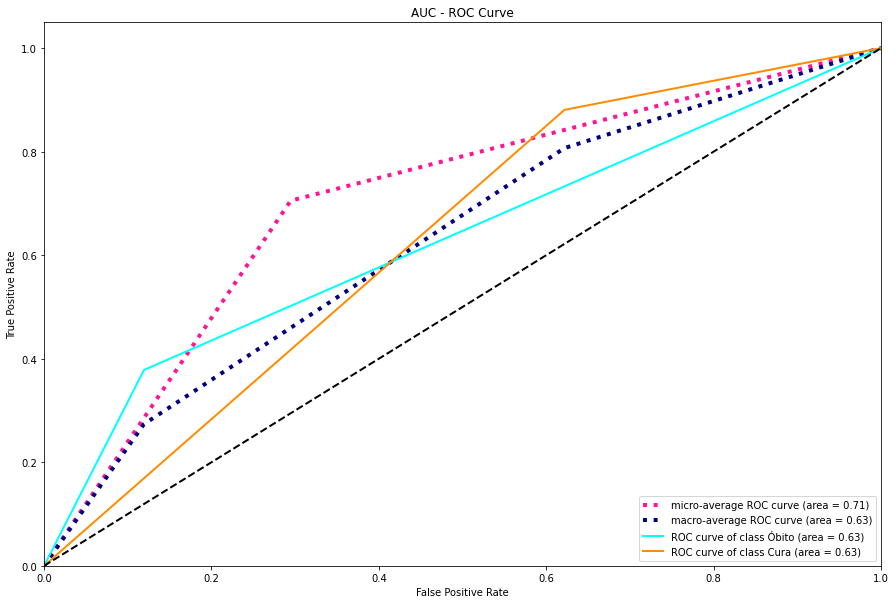

None

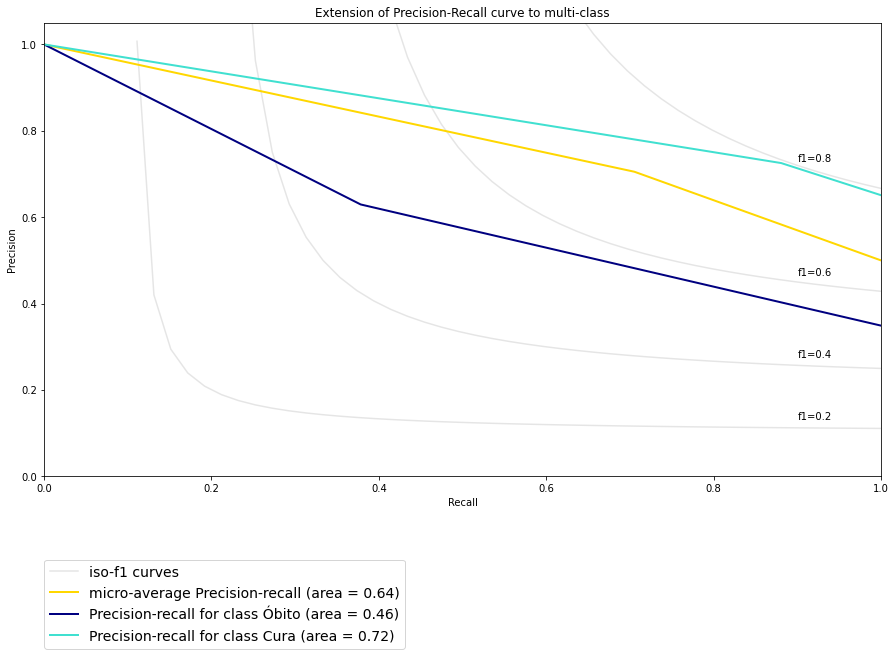

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.47     0.63     0.46       0.63    0.38         0.88      0.71
1    Cura  0.80     0.63     0.72       0.73    0.88         0.38      0.71
2   Média  0.64     0.63     0.59       0.68    0.63         0.63      0.71
Epoch 1/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5959 - acc: 0.6829 - precision_m: 0.6829 - recall_m: 0.6829 - f1_m: 0.6829 - auc: 0.7445
Epoch 2/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5813 - acc: 0.6927 - precision_m: 0.6927 - recall_m: 0.6927 - f1_m: 0.6927 - auc: 0.7620
Epoch 3/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5807 - acc: 0.6932 - precision_m: 0.6932 - recall_m: 0.6932 - f1_m: 0.6932 - auc: 0.7626
Epoch 4/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5800 - acc: 0.6938 - precision_m: 0.6938 - recall_m: 0.6938 - f1_m: 0.6938 - auc: 0.7634
Epoch 5/79
20521

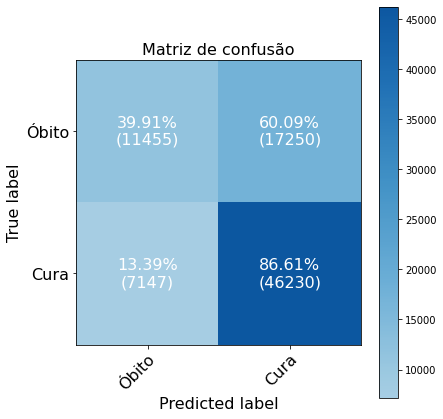

None

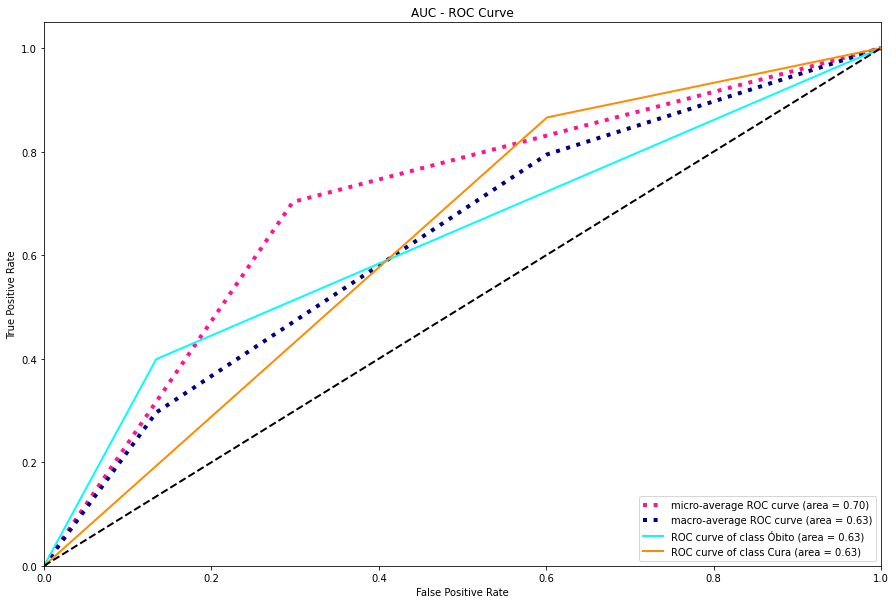

None

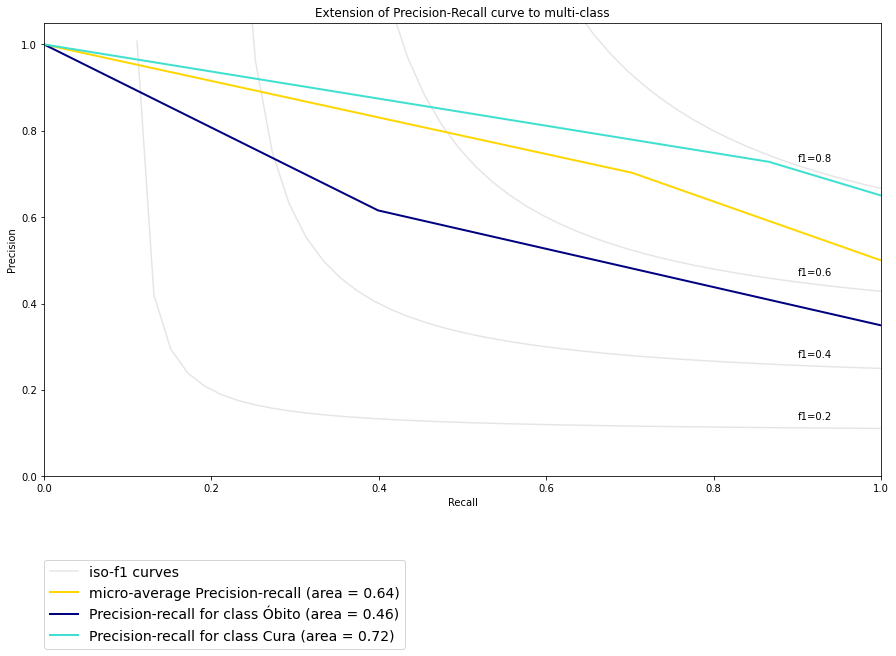

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.48     0.63     0.46       0.62    0.40         0.87       0.7
1    Cura  0.79     0.63     0.72       0.73    0.87         0.40       0.7
2   Média  0.64     0.63     0.59       0.68    0.64         0.64       0.7
Epoch 1/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5947 - acc: 0.6836 - precision_m: 0.6836 - recall_m: 0.6836 - f1_m: 0.6836 - auc: 0.7463
Epoch 2/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5817 - acc: 0.6925 - precision_m: 0.6925 - recall_m: 0.6925 - f1_m: 0.6925 - auc: 0.7616
Epoch 3/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5812 - acc: 0.6930 - precision_m: 0.6930 - recall_m: 0.6930 - f1_m: 0.6930 - auc: 0.7621
Epoch 4/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5809 - acc: 0.6934 - precision_m: 0.6934 - recall_m: 0.6934 - f1_m: 0.6934 - auc: 0.7625
Epoch 5/79
20521

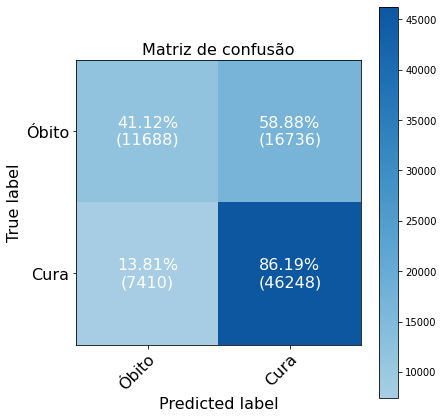

None

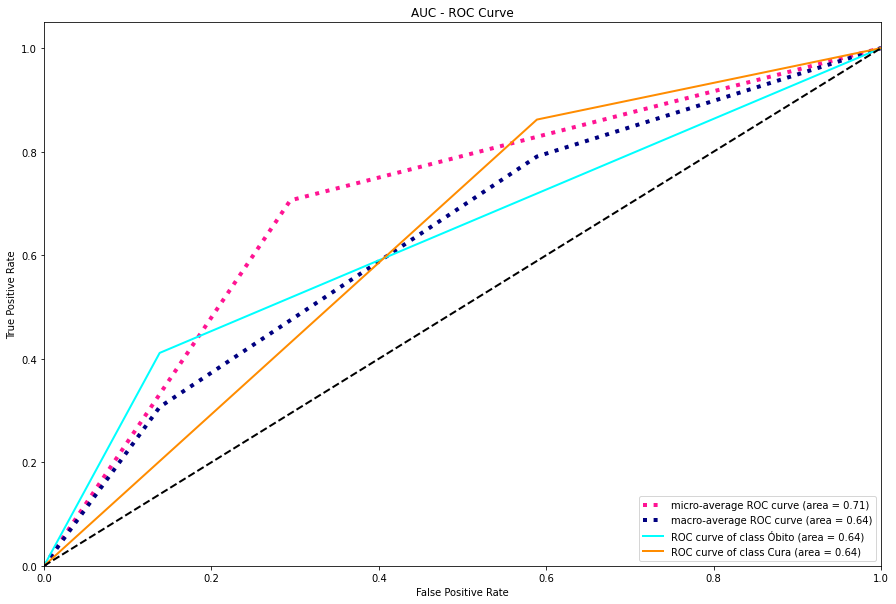

None

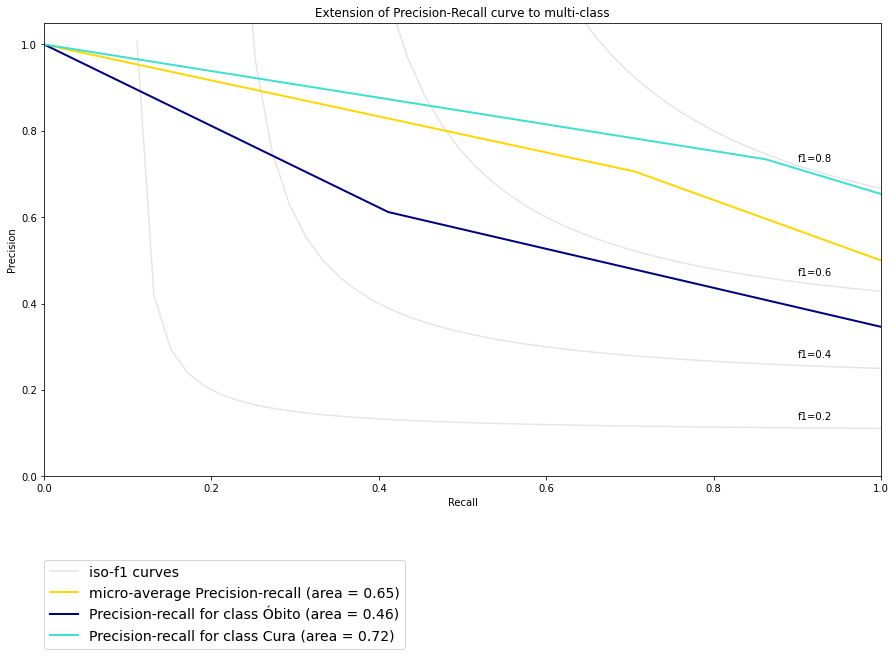

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.49     0.64     0.46       0.61    0.41         0.86      0.71
1    Cura  0.79     0.64     0.72       0.73    0.86         0.41      0.71
2   Média  0.64     0.64     0.59       0.67    0.64         0.64      0.71
Epoch 1/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.6051 - acc: 0.6772 - precision_m: 0.6772 - recall_m: 0.6772 - f1_m: 0.6772 - auc: 0.7320
Epoch 2/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5816 - acc: 0.6923 - precision_m: 0.6923 - recall_m: 0.6923 - f1_m: 0.6923 - auc: 0.7616
Epoch 3/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5812 - acc: 0.6929 - precision_m: 0.6929 - recall_m: 0.6929 - f1_m: 0.6929 - auc: 0.7621
Epoch 4/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5809 - acc: 0.6932 - precision_m: 0.6932 - recall_m: 0.6932 - f1_m: 0.6932 - auc: 0.7624
Epoch 5/79
20521

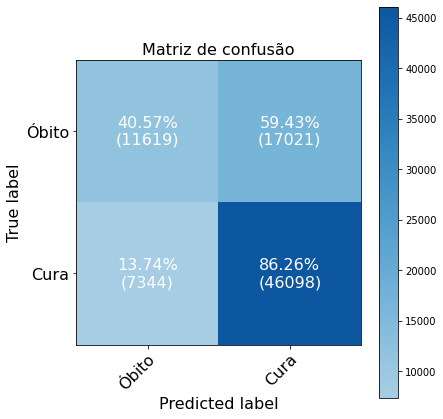

None

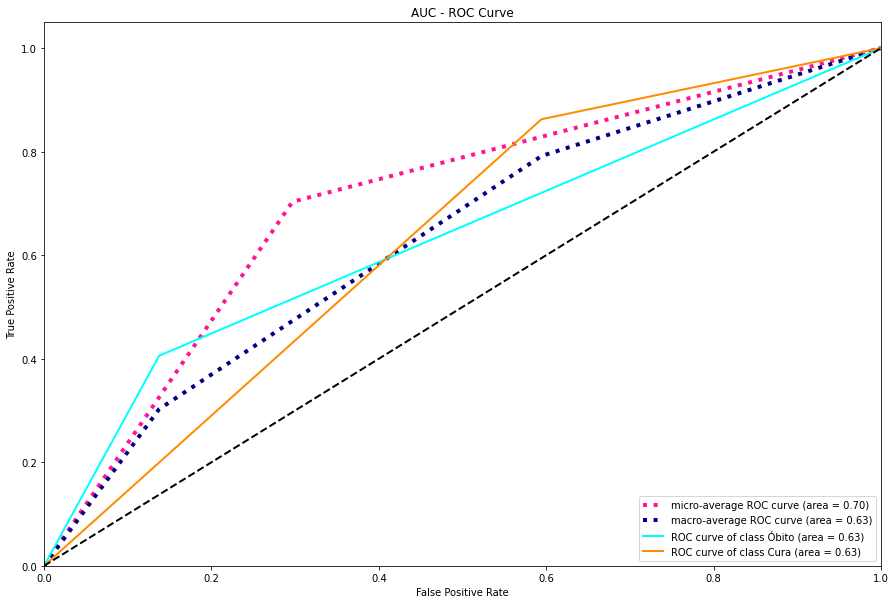

None

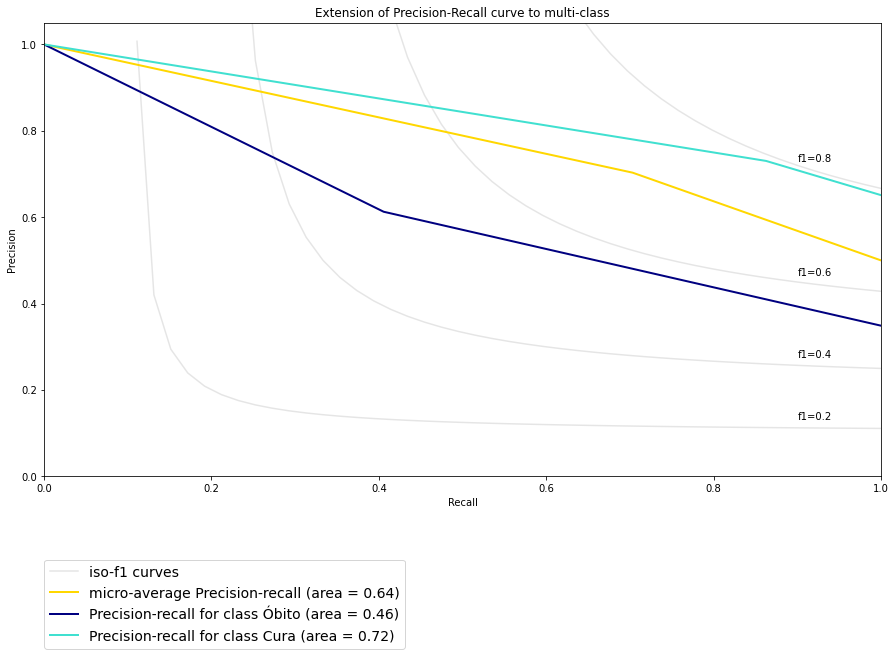

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.49     0.63     0.46       0.61    0.41         0.86       0.7
1    Cura  0.79     0.63     0.72       0.73    0.86         0.41       0.7
2   Média  0.64     0.63     0.59       0.67    0.64         0.64       0.7
Epoch 1/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5970 - acc: 0.6820 - precision_m: 0.6820 - recall_m: 0.6820 - f1_m: 0.6820 - auc: 0.7431
Epoch 2/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5787 - acc: 0.6948 - precision_m: 0.6948 - recall_m: 0.6948 - f1_m: 0.6948 - auc: 0.7647
Epoch 3/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5752 - acc: 0.6975 - precision_m: 0.6975 - recall_m: 0.6975 - f1_m: 0.6975 - auc: 0.7681
Epoch 4/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5741 - acc: 0.6983 - precision_m: 0.6983 - recall_m: 0.6983 - f1_m: 0.6983 - auc: 0.7691
Epoch 5/79
20521

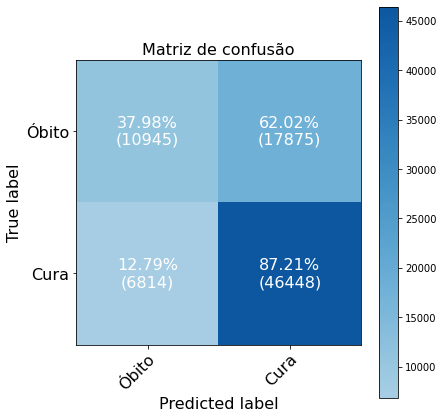

None

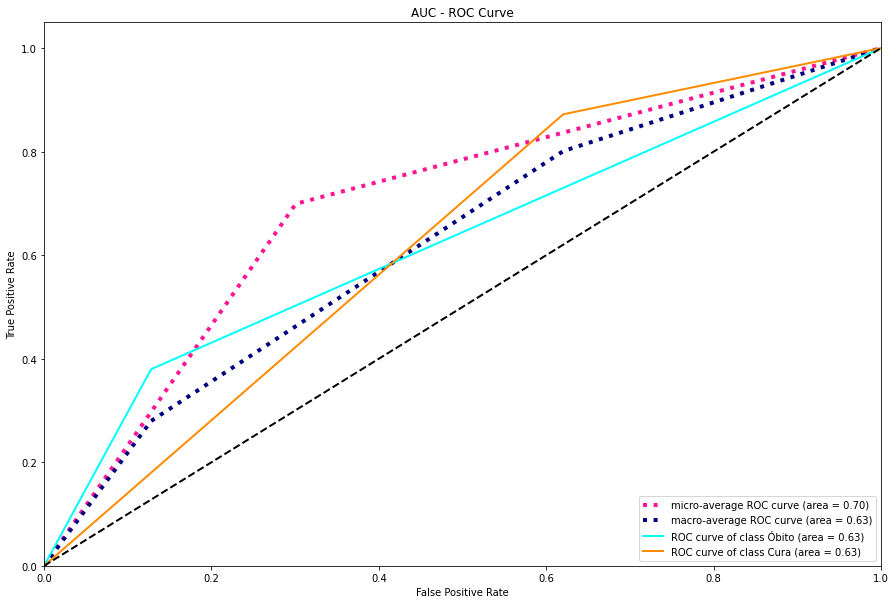

None

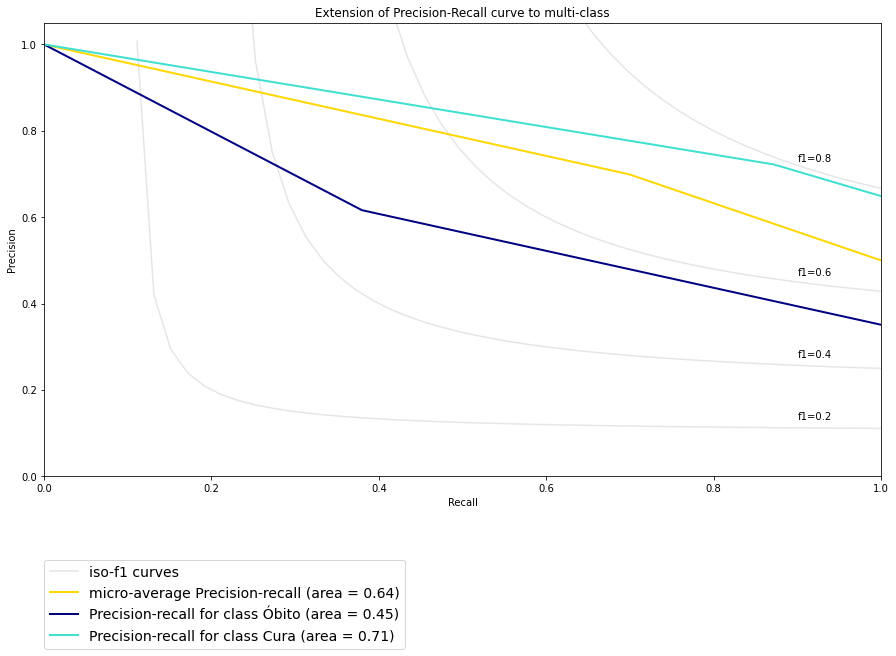

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.47     0.63     0.45       0.62    0.38         0.87       0.7
1    Cura  0.79     0.63     0.71       0.72    0.87         0.38       0.7
2   Média  0.63     0.63     0.58       0.67    0.62         0.62       0.7
Epoch 1/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.6205 - acc: 0.6672 - precision_m: 0.6673 - recall_m: 0.6673 - f1_m: 0.6673 - auc: 0.7074
Epoch 2/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5818 - acc: 0.6922 - precision_m: 0.6923 - recall_m: 0.6923 - f1_m: 0.6923 - auc: 0.7614
Epoch 3/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5803 - acc: 0.6934 - precision_m: 0.6935 - recall_m: 0.6935 - f1_m: 0.6935 - auc: 0.7630
Epoch 4/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5768 - acc: 0.6966 - precision_m: 0.6966 - recall_m: 0.6966 - f1_m: 0.6966 - auc: 0.7667
Epoch 5/79
20521

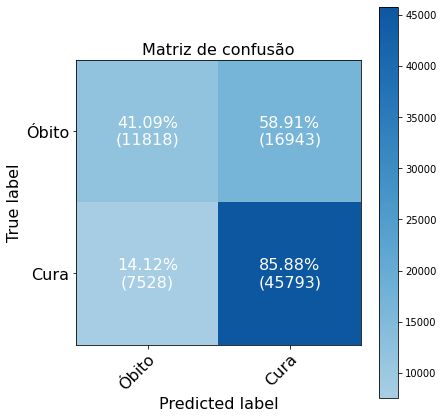

None

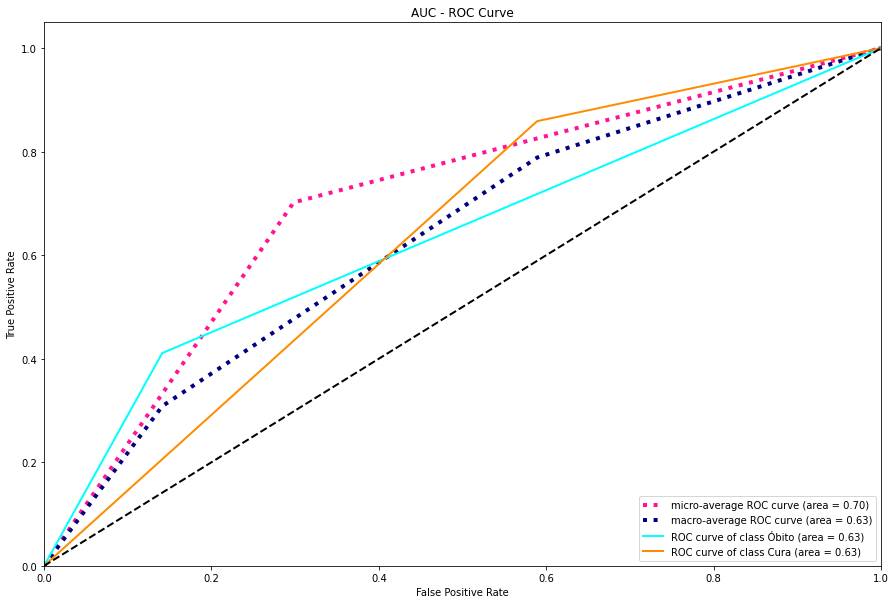

None

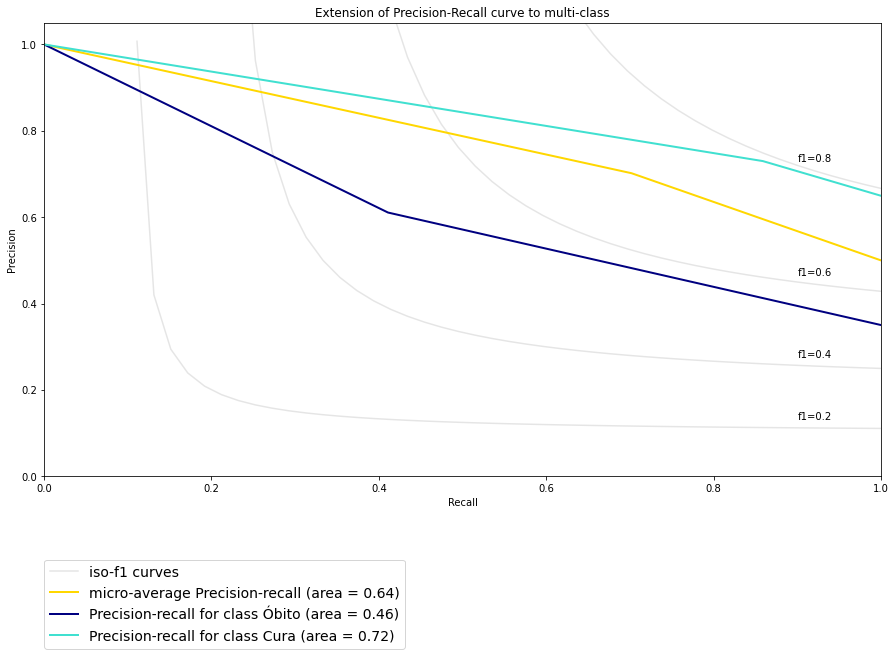

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.49     0.63     0.46       0.61    0.41         0.86       0.7
1    Cura  0.79     0.63     0.72       0.73    0.86         0.41       0.7
2   Média  0.64     0.63     0.59       0.67    0.64         0.64       0.7
Epoch 1/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5941 - acc: 0.6838 - precision_m: 0.6838 - recall_m: 0.6838 - f1_m: 0.6838 - auc: 0.7469
Epoch 2/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5779 - acc: 0.6954 - precision_m: 0.6954 - recall_m: 0.6954 - f1_m: 0.6954 - auc: 0.7655
Epoch 3/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5749 - acc: 0.6982 - precision_m: 0.6982 - recall_m: 0.6982 - f1_m: 0.6982 - auc: 0.7685
Epoch 4/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5741 - acc: 0.6990 - precision_m: 0.6990 - recall_m: 0.6990 - f1_m: 0.6990 - auc: 0.7693
Epoch 5/79
20521

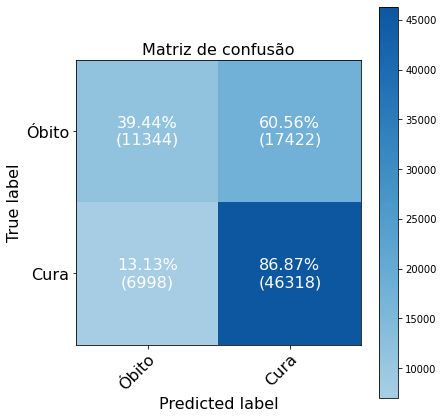

None

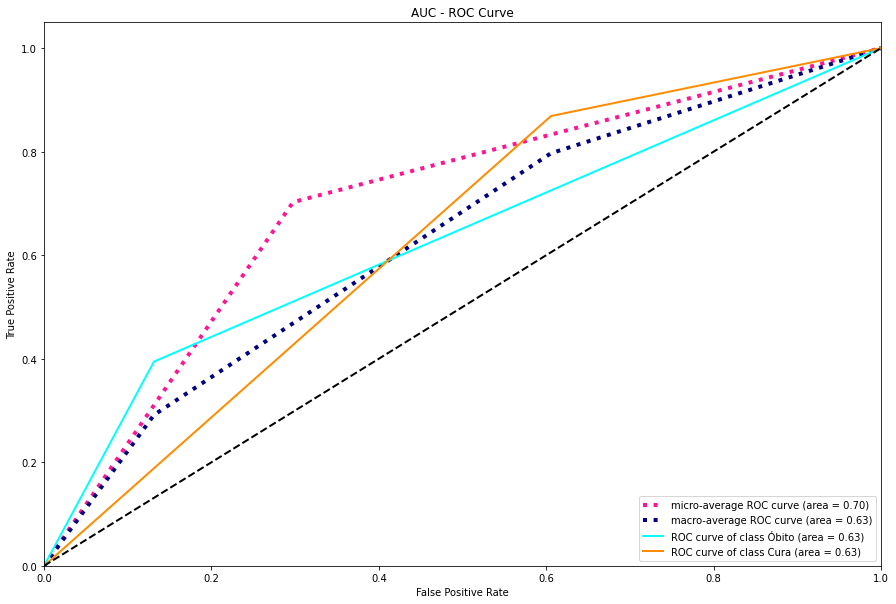

None

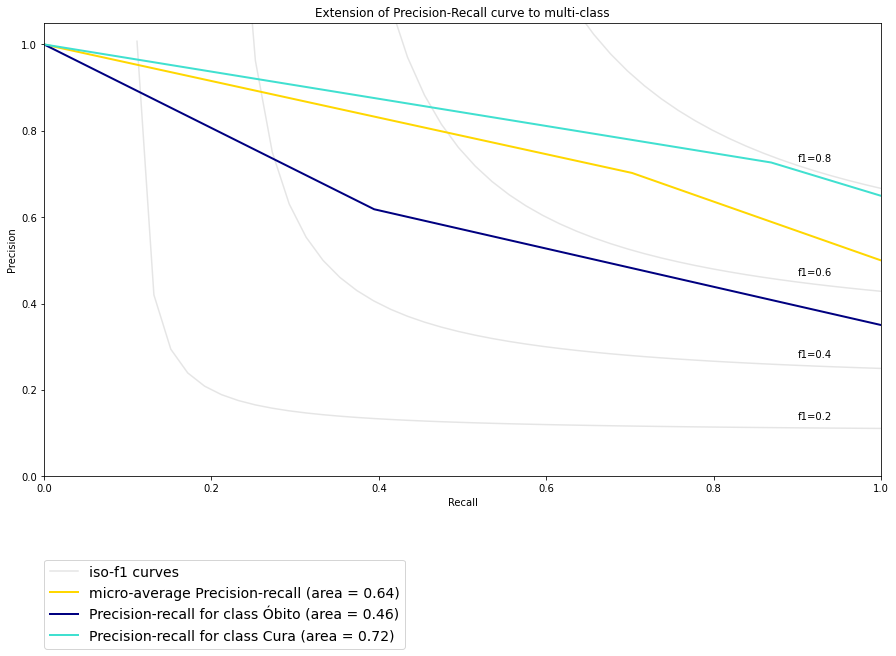

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.48     0.63     0.46       0.62    0.39         0.87       0.7
1    Cura  0.79     0.63     0.72       0.73    0.87         0.39       0.7
2   Média  0.64     0.63     0.59       0.68    0.63         0.63       0.7
Epoch 1/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5936 - acc: 0.6843 - precision_m: 0.6844 - recall_m: 0.6844 - f1_m: 0.6844 - auc: 0.7476
Epoch 2/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5797 - acc: 0.6939 - precision_m: 0.6940 - recall_m: 0.6940 - f1_m: 0.6940 - auc: 0.7636
Epoch 3/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5761 - acc: 0.6967 - precision_m: 0.6967 - recall_m: 0.6967 - f1_m: 0.6967 - auc: 0.7671
Epoch 4/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5743 - acc: 0.6984 - precision_m: 0.6984 - recall_m: 0.6984 - f1_m: 0.6984 - auc: 0.7690
Epoch 5/79
20521

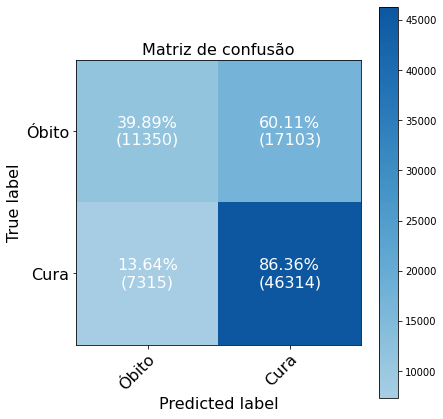

None

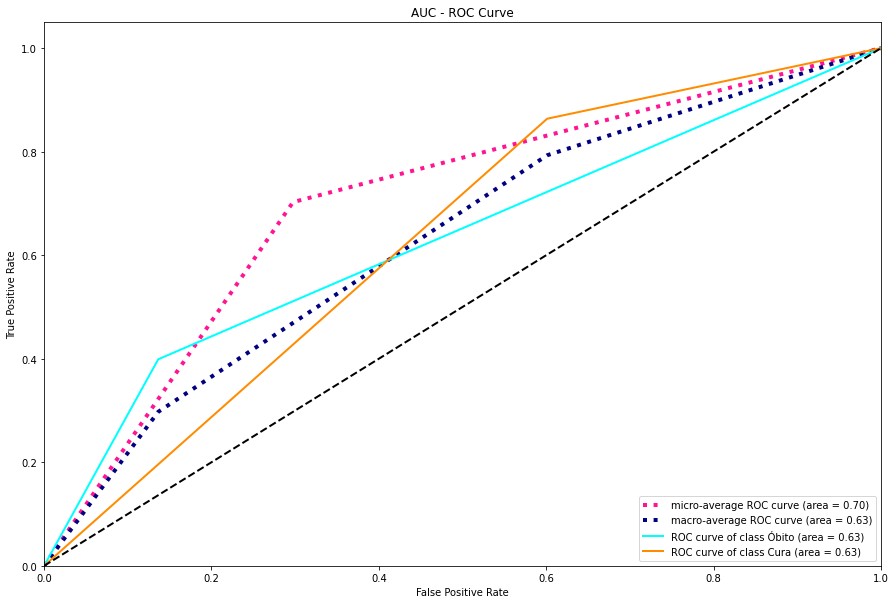

None

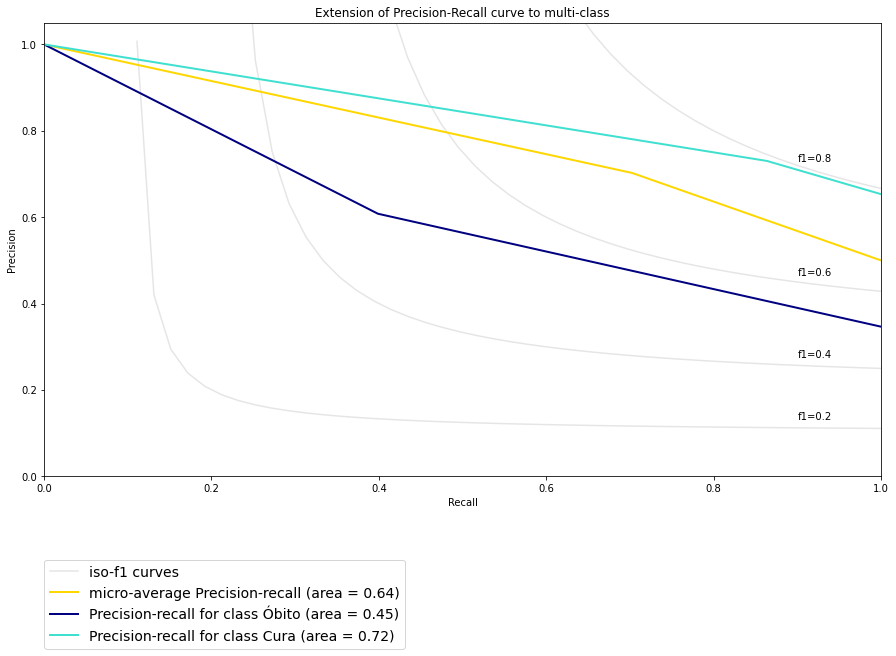

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.48     0.63     0.45       0.61    0.40         0.86       0.7
1    Cura  0.79     0.63     0.72       0.73    0.86         0.40       0.7
2   Média  0.64     0.63     0.58       0.67    0.63         0.63       0.7
Epoch 1/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.6007 - acc: 0.6799 - precision_m: 0.6799 - recall_m: 0.6799 - f1_m: 0.6799 - auc: 0.7382
Epoch 2/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5797 - acc: 0.6938 - precision_m: 0.6938 - recall_m: 0.6938 - f1_m: 0.6938 - auc: 0.7636
Epoch 3/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5757 - acc: 0.6976 - precision_m: 0.6976 - recall_m: 0.6976 - f1_m: 0.6976 - auc: 0.7678
Epoch 4/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5742 - acc: 0.6988 - precision_m: 0.6988 - recall_m: 0.6988 - f1_m: 0.6988 - auc: 0.7692
Epoch 5/79
20521

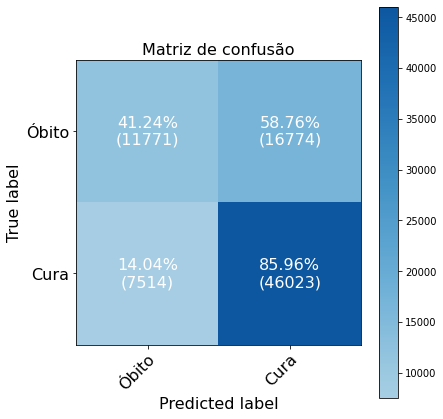

None

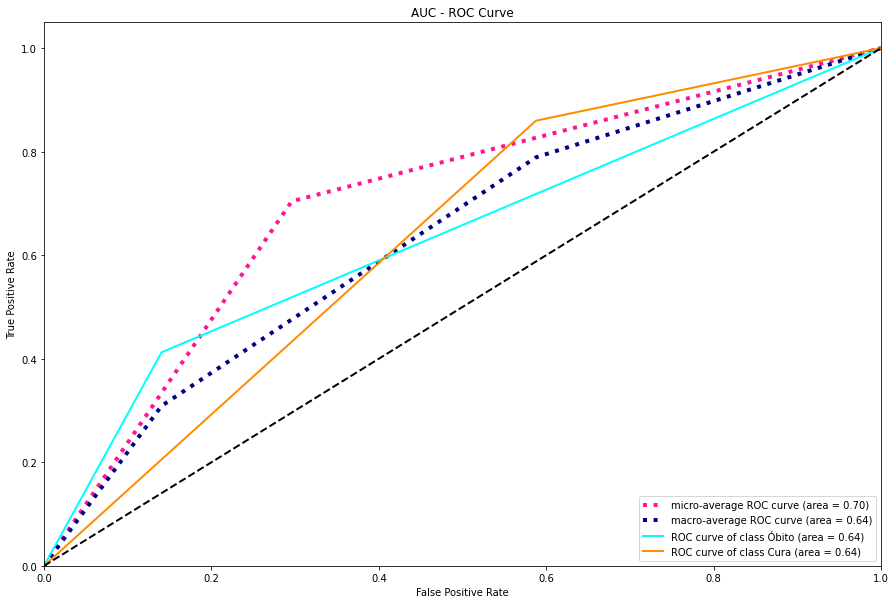

None

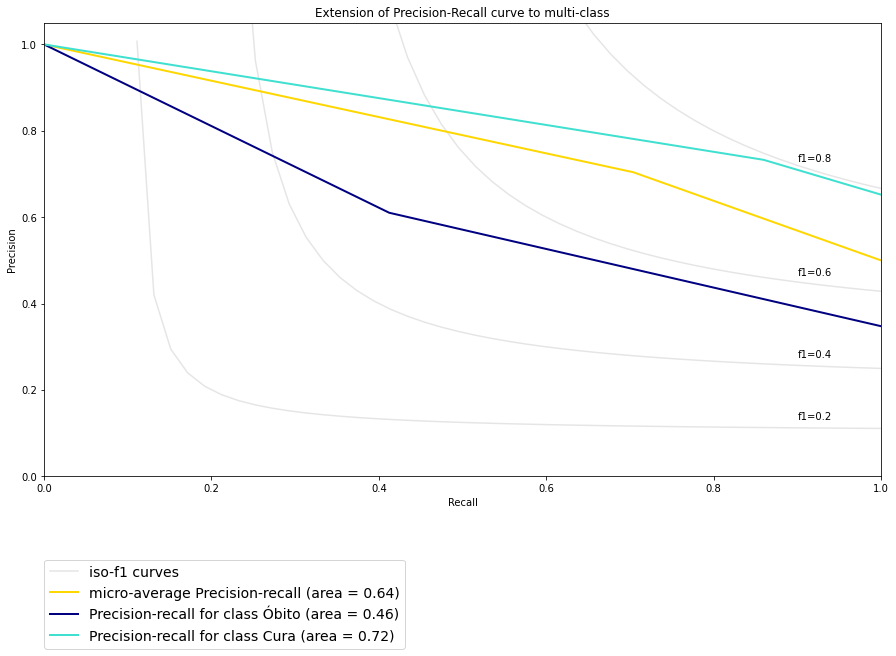

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.49     0.64     0.46       0.61    0.41         0.86       0.7
1    Cura  0.79     0.64     0.72       0.73    0.86         0.41       0.7
2   Média  0.64     0.64     0.59       0.67    0.64         0.64       0.7
Epoch 1/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5988 - acc: 0.6811 - precision_m: 0.6811 - recall_m: 0.6811 - f1_m: 0.6811 - auc: 0.7407
Epoch 2/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5785 - acc: 0.6952 - precision_m: 0.6952 - recall_m: 0.6952 - f1_m: 0.6952 - auc: 0.7650
Epoch 3/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5747 - acc: 0.6986 - precision_m: 0.6986 - recall_m: 0.6986 - f1_m: 0.6986 - auc: 0.7688
Epoch 4/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5738 - acc: 0.6994 - precision_m: 0.6994 - recall_m: 0.6994 - f1_m: 0.6994 - auc: 0.7696
Epoch 5/79
20521

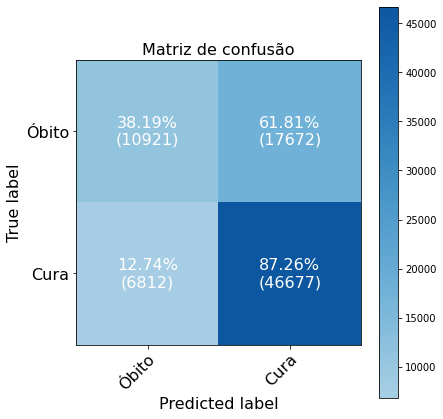

None

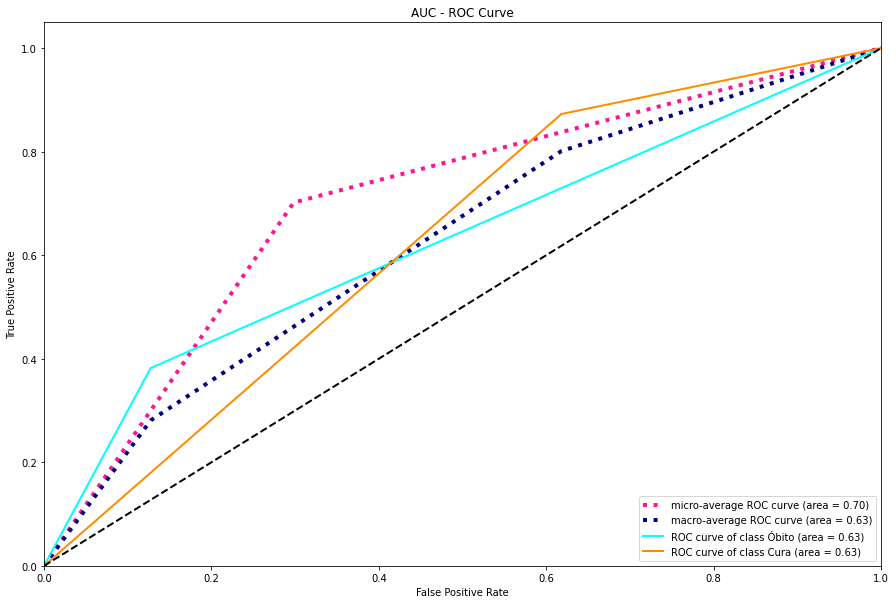

None

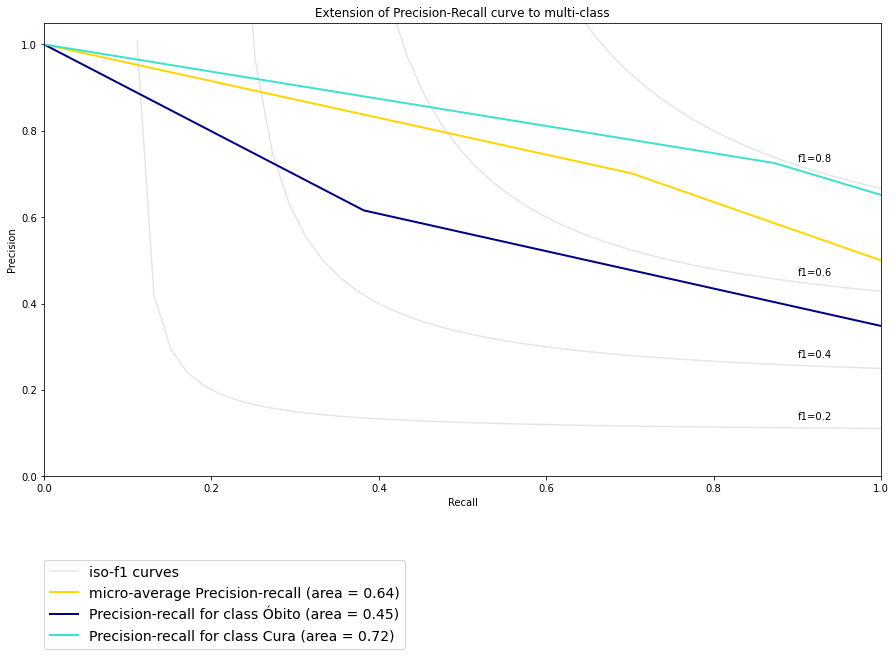

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.47     0.63     0.45       0.62    0.38         0.87       0.7
1    Cura  0.79     0.63     0.72       0.73    0.87         0.38       0.7
2   Média  0.63     0.63     0.58       0.68    0.62         0.62       0.7
Epoch 1/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.6004 - acc: 0.6801 - precision_m: 0.6801 - recall_m: 0.6801 - f1_m: 0.6801 - auc: 0.7384
Epoch 2/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5768 - acc: 0.6965 - precision_m: 0.6965 - recall_m: 0.6965 - f1_m: 0.6965 - auc: 0.7666
Epoch 3/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5743 - acc: 0.6985 - precision_m: 0.6986 - recall_m: 0.6986 - f1_m: 0.6986 - auc: 0.7691
Epoch 4/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5736 - acc: 0.6994 - precision_m: 0.6994 - recall_m: 0.6994 - f1_m: 0.6994 - auc: 0.7698
Epoch 5/79
20521

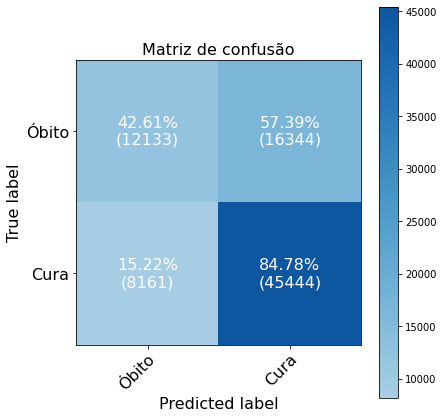

None

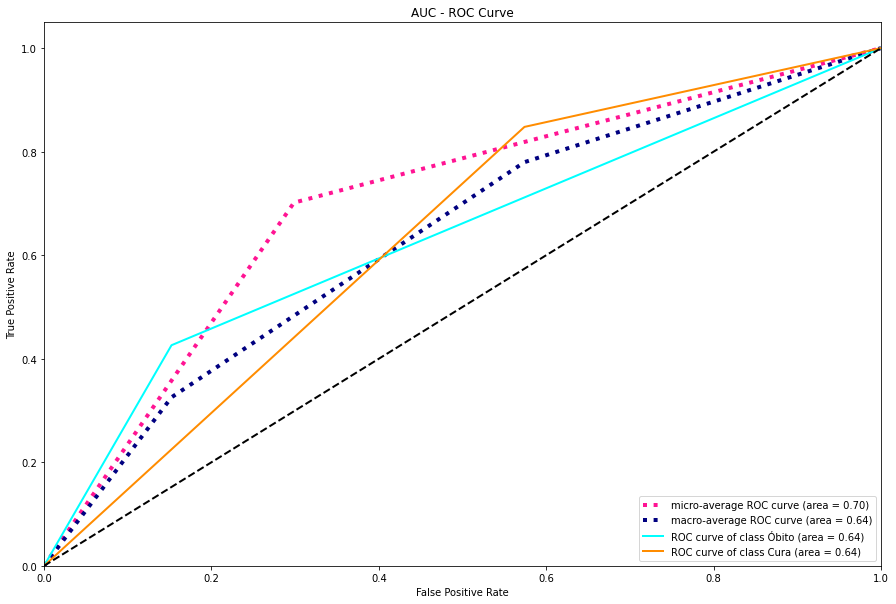

None

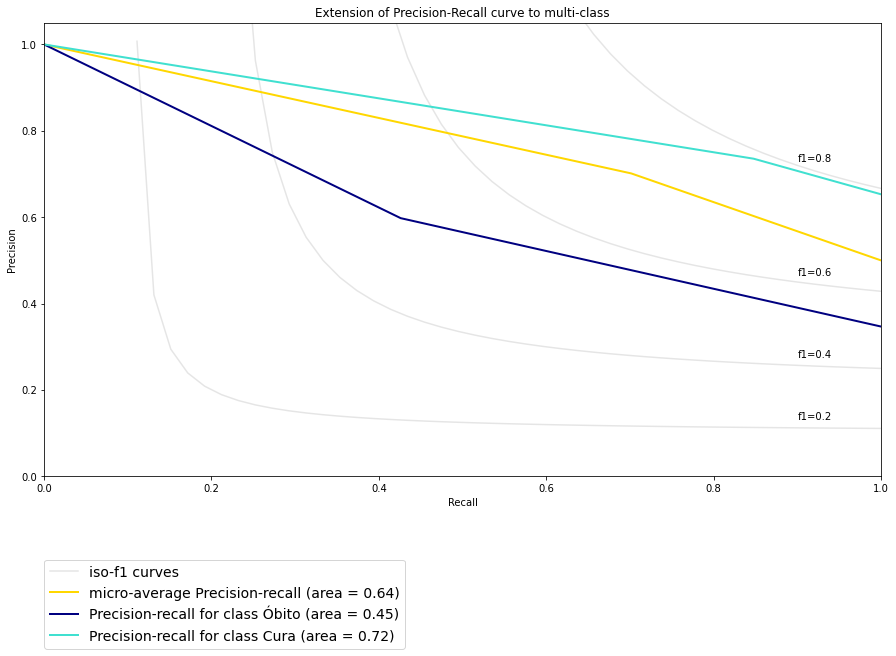

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.50     0.64     0.45       0.60    0.43         0.85       0.7
1    Cura  0.79     0.64     0.72       0.74    0.85         0.43       0.7
2   Média  0.64     0.64     0.58       0.67    0.64         0.64       0.7
Epoch 1/79
20521/20521 [==============================] - 28s 1ms/step - loss: 0.5972 - acc: 0.6817 - precision_m: 0.6818 - recall_m: 0.6818 - f1_m: 0.6818 - auc: 0.7429
Epoch 2/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5795 - acc: 0.6939 - precision_m: 0.6939 - recall_m: 0.6939 - f1_m: 0.6939 - auc: 0.7638
Epoch 3/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5759 - acc: 0.6969 - precision_m: 0.6969 - recall_m: 0.6969 - f1_m: 0.6969 - auc: 0.7674
Epoch 4/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5742 - acc: 0.6985 - precision_m: 0.6985 - recall_m: 0.6985 - f1_m: 0.6985 - auc: 0.7691
Epoch 5/79
20521

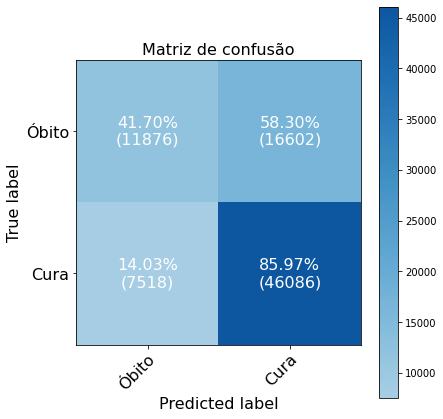

None

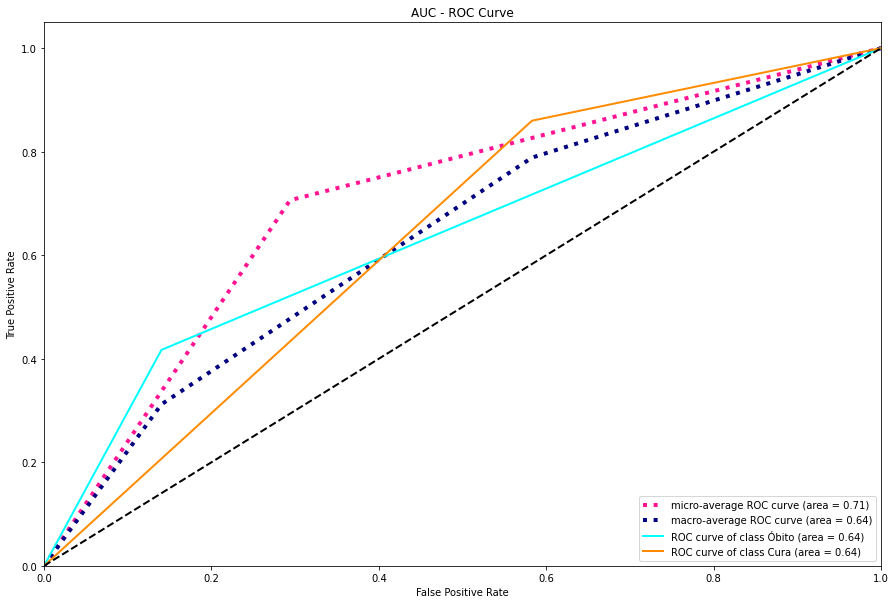

None

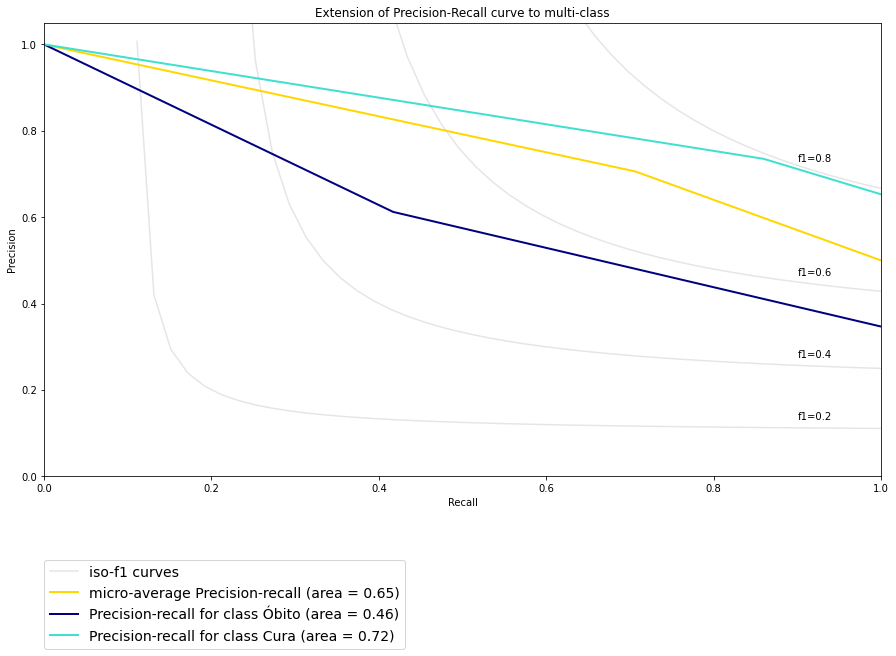

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.50     0.64     0.46       0.61    0.42         0.86      0.71
1    Cura  0.79     0.64     0.72       0.74    0.86         0.42      0.71
2   Média  0.64     0.64     0.59       0.68    0.64         0.64      0.71
Epoch 1/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.6079 - acc: 0.6752 - precision_m: 0.6753 - recall_m: 0.6753 - f1_m: 0.6753 - auc: 0.7277
Epoch 2/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5773 - acc: 0.6963 - precision_m: 0.6964 - recall_m: 0.6964 - f1_m: 0.6964 - auc: 0.7661
Epoch 3/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5745 - acc: 0.6984 - precision_m: 0.6984 - recall_m: 0.6984 - f1_m: 0.6984 - auc: 0.7689
Epoch 4/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5738 - acc: 0.6991 - precision_m: 0.6991 - recall_m: 0.6991 - f1_m: 0.6991 - auc: 0.7696
Epoch 5/79
20521

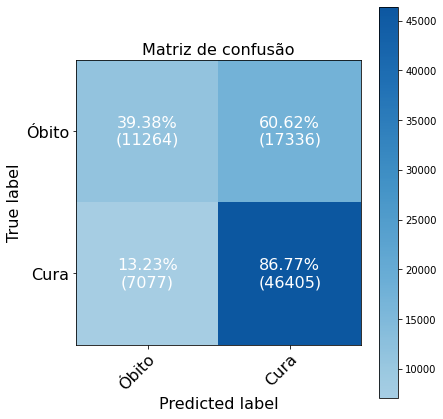

None

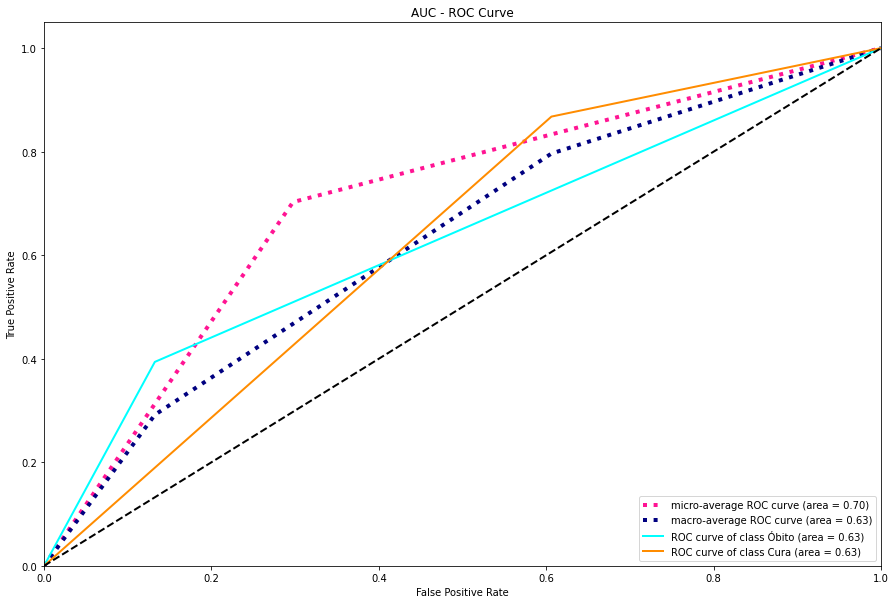

None

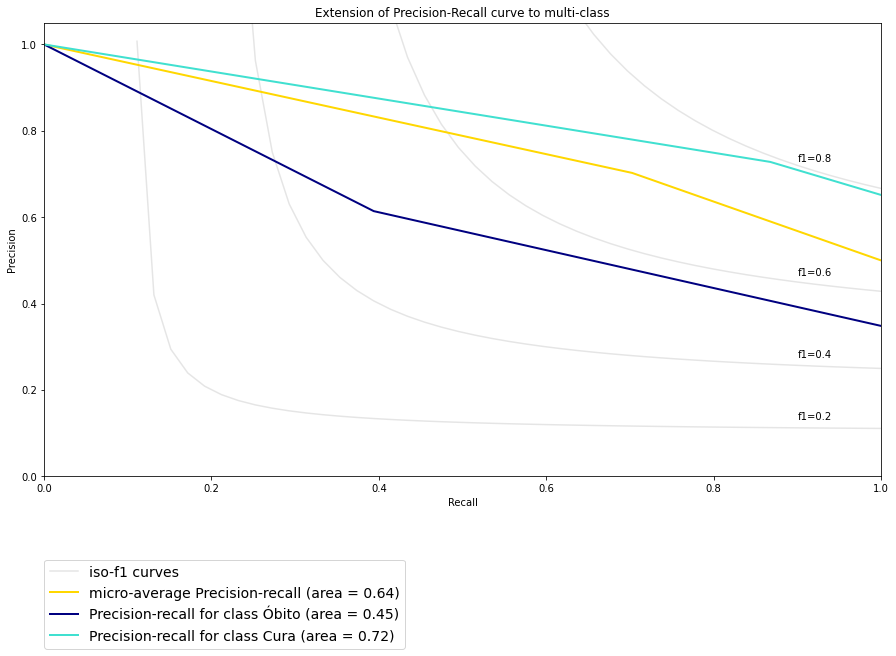

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.48     0.63     0.45       0.61    0.39         0.87       0.7
1    Cura  0.79     0.63     0.72       0.73    0.87         0.39       0.7
2   Média  0.64     0.63     0.58       0.67    0.63         0.63       0.7
Epoch 1/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5957 - acc: 0.6830 - precision_m: 0.6830 - recall_m: 0.6830 - f1_m: 0.6830 - auc: 0.7450
Epoch 2/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5816 - acc: 0.6926 - precision_m: 0.6926 - recall_m: 0.6926 - f1_m: 0.6926 - auc: 0.7617
Epoch 3/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5792 - acc: 0.6944 - precision_m: 0.6945 - recall_m: 0.6945 - f1_m: 0.6945 - auc: 0.7642
Epoch 4/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5753 - acc: 0.6976 - precision_m: 0.6976 - recall_m: 0.6976 - f1_m: 0.6976 - auc: 0.7681
Epoch 5/79
20521

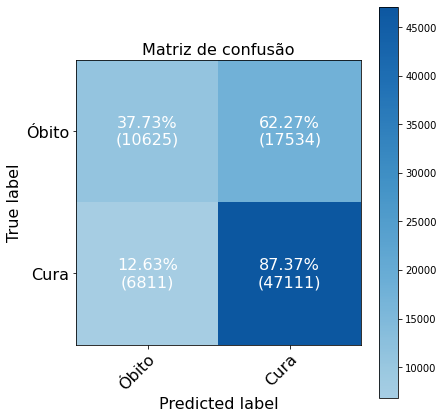

None

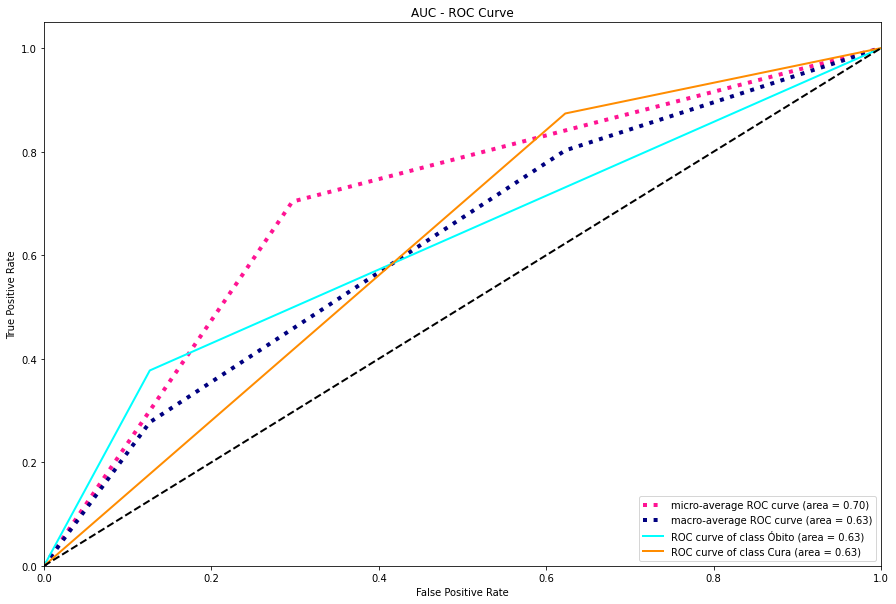

None

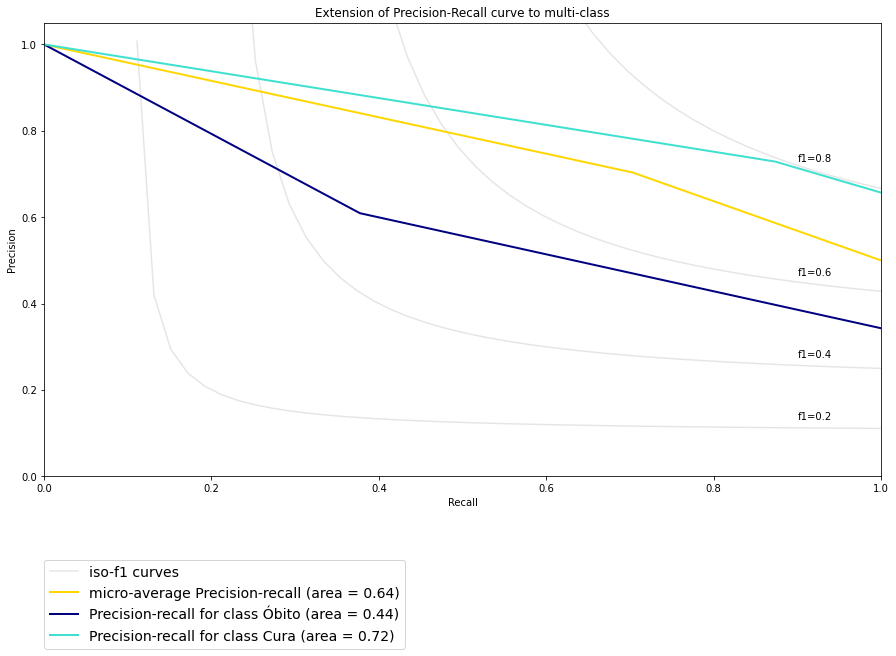

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.47     0.63     0.44       0.61    0.38         0.87       0.7
1    Cura  0.79     0.63     0.72       0.73    0.87         0.38       0.7
2   Média  0.63     0.63     0.58       0.67    0.62         0.62       0.7
Epoch 1/79
20521/20521 [==============================] - 28s 1ms/step - loss: 0.6029 - acc: 0.6784 - precision_m: 0.6784 - recall_m: 0.6784 - f1_m: 0.6784 - auc: 0.7350
Epoch 2/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5813 - acc: 0.6928 - precision_m: 0.6928 - recall_m: 0.6928 - f1_m: 0.6928 - auc: 0.7620
Epoch 3/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5799 - acc: 0.6940 - precision_m: 0.6941 - recall_m: 0.6941 - f1_m: 0.6941 - auc: 0.7635
Epoch 4/79
20521/20521 [==============================] - 26s 1ms/step - loss: 0.5771 - acc: 0.6965 - precision_m: 0.6965 - recall_m: 0.6965 - f1_m: 0.6965 - auc: 0.7664
Epoch 5/79
20521

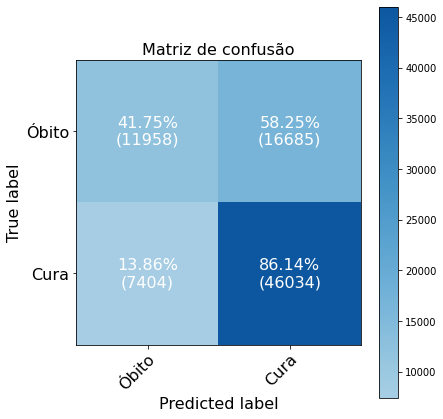

None

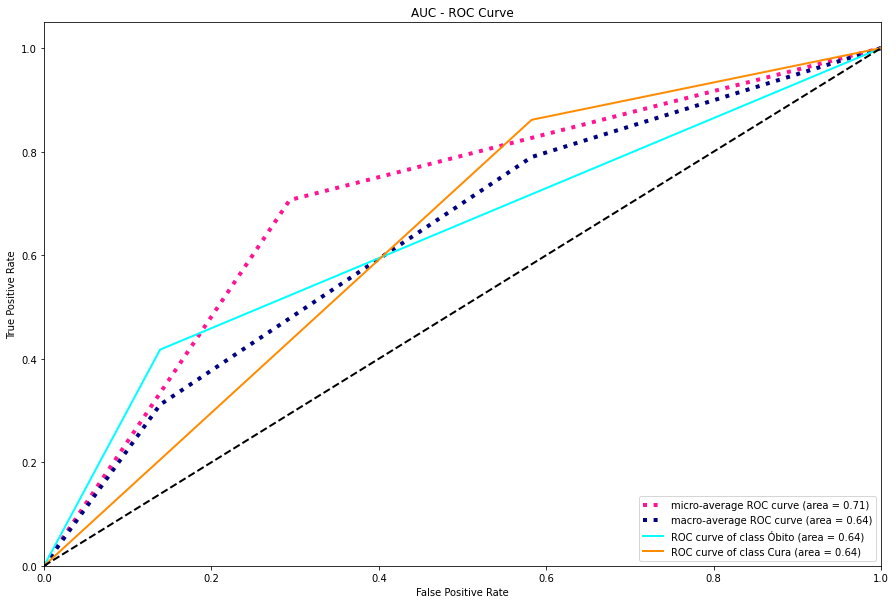

None

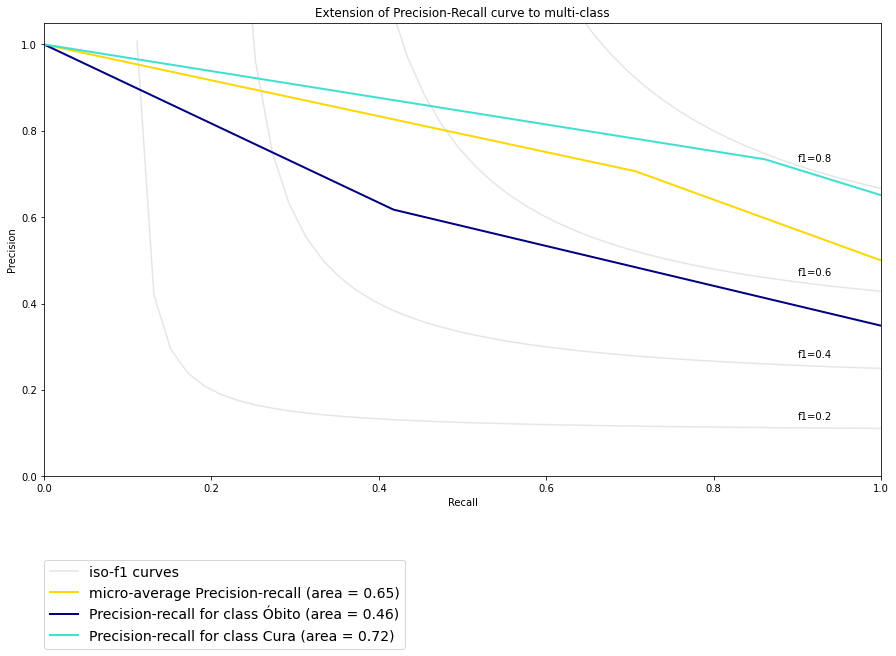

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.50     0.64     0.46       0.62    0.42         0.86      0.71
1    Cura  0.79     0.64     0.72       0.73    0.86         0.42      0.71
2   Média  0.64     0.64     0.59       0.68    0.64         0.64      0.71
Epoch 1/79
20521/20521 [==============================] - 28s 1ms/step - loss: 0.6094 - acc: 0.6746 - precision_m: 0.6746 - recall_m: 0.6746 - f1_m: 0.6746 - auc: 0.7254
Epoch 2/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5807 - acc: 0.6934 - precision_m: 0.6934 - recall_m: 0.6934 - f1_m: 0.6934 - auc: 0.7626
Epoch 3/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5771 - acc: 0.6964 - precision_m: 0.6965 - recall_m: 0.6965 - f1_m: 0.6965 - auc: 0.7663
Epoch 4/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5744 - acc: 0.6983 - precision_m: 0.6983 - recall_m: 0.6983 - f1_m: 0.6983 - auc: 0.7688
Epoch 5/79
20521

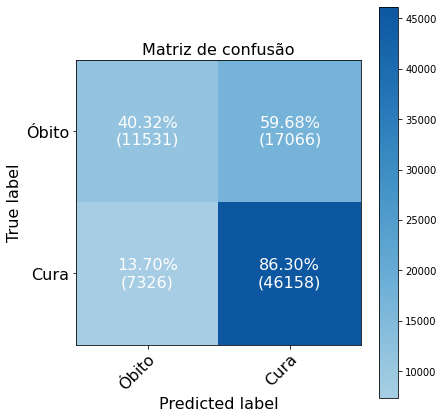

None

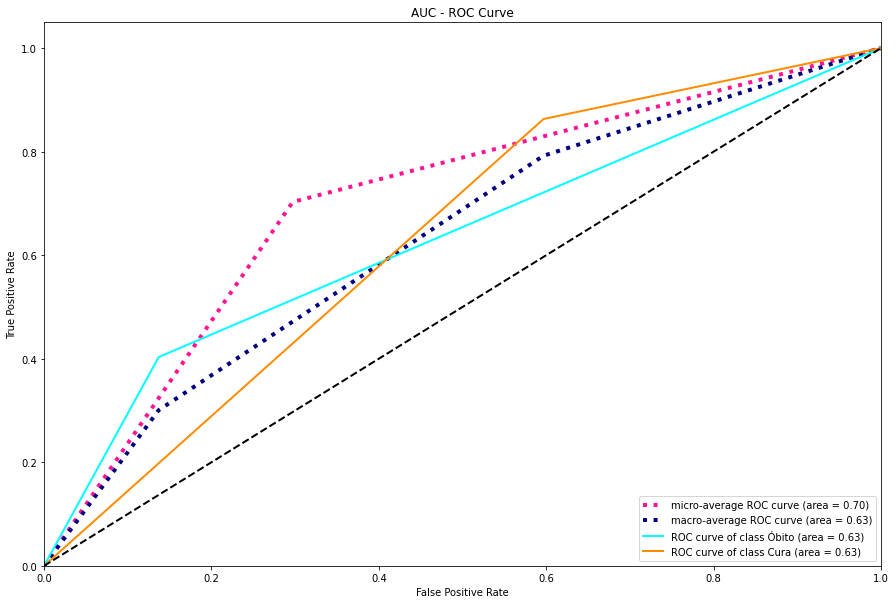

None

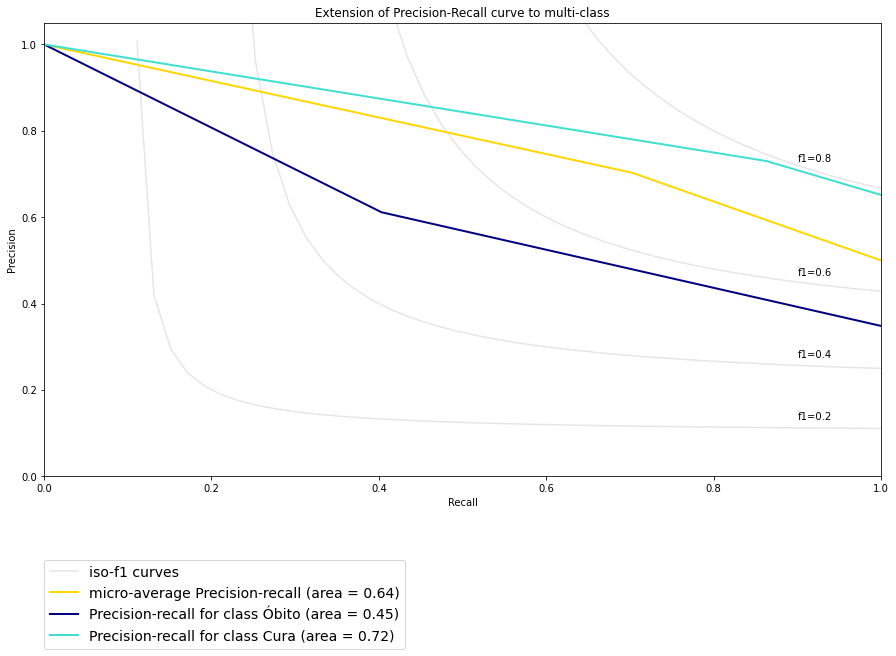

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.49     0.63     0.45       0.61    0.40         0.86       0.7
1    Cura  0.79     0.63     0.72       0.73    0.86         0.40       0.7
2   Média  0.64     0.63     0.58       0.67    0.63         0.63       0.7
Epoch 1/79
20521/20521 [==============================] - 28s 1ms/step - loss: 0.5957 - acc: 0.6829 - precision_m: 0.6829 - recall_m: 0.6829 - f1_m: 0.6829 - auc: 0.7448
Epoch 2/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5777 - acc: 0.6959 - precision_m: 0.6959 - recall_m: 0.6959 - f1_m: 0.6959 - auc: 0.7657
Epoch 3/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5745 - acc: 0.6988 - precision_m: 0.6988 - recall_m: 0.6988 - f1_m: 0.6988 - auc: 0.7688
Epoch 4/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5735 - acc: 0.6998 - precision_m: 0.6998 - recall_m: 0.6998 - f1_m: 0.6998 - auc: 0.7698
Epoch 5/79
20521

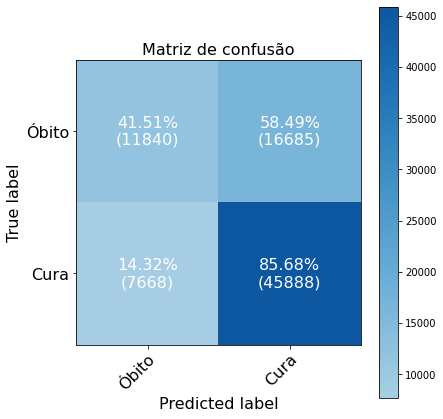

None

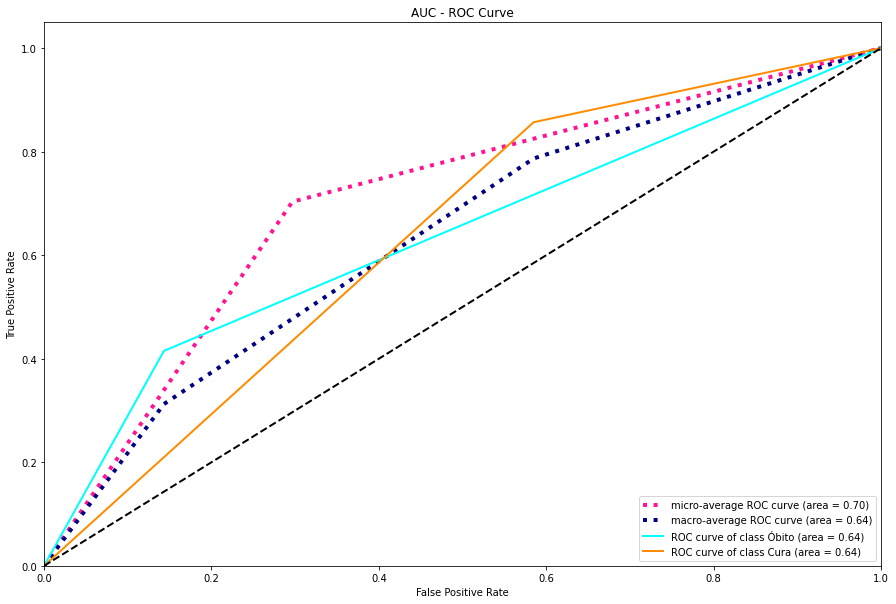

None

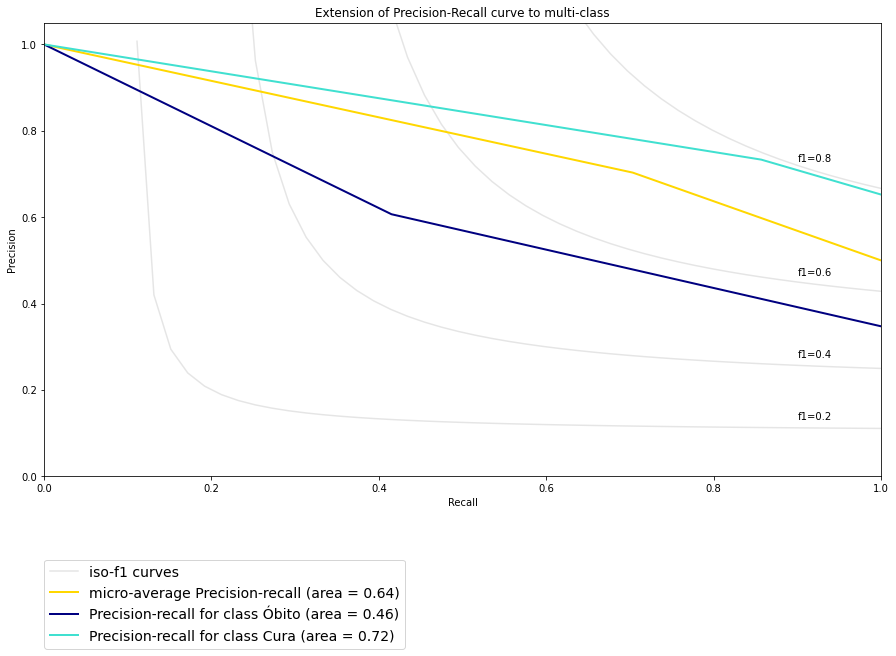

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.49     0.64     0.46       0.61    0.42         0.86       0.7
1    Cura  0.79     0.64     0.72       0.73    0.86         0.42       0.7
2   Média  0.64     0.64     0.59       0.67    0.64         0.64       0.7
Epoch 1/79
20521/20521 [==============================] - 28s 1ms/step - loss: 0.6096 - acc: 0.6739 - precision_m: 0.6739 - recall_m: 0.6739 - f1_m: 0.6739 - auc: 0.7251
Epoch 2/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5801 - acc: 0.6938 - precision_m: 0.6938 - recall_m: 0.6938 - f1_m: 0.6938 - auc: 0.7632
Epoch 3/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5762 - acc: 0.6972 - precision_m: 0.6972 - recall_m: 0.6972 - f1_m: 0.6972 - auc: 0.7673
Epoch 4/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5743 - acc: 0.6991 - precision_m: 0.6991 - recall_m: 0.6991 - f1_m: 0.6991 - auc: 0.7691
Epoch 5/79
20521

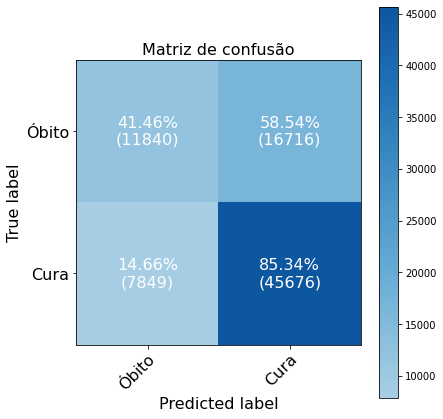

None

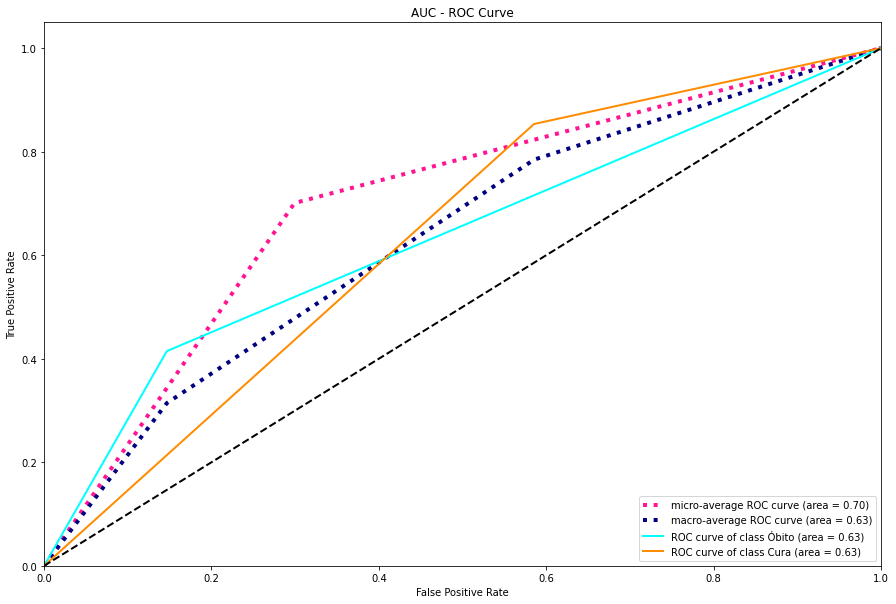

None

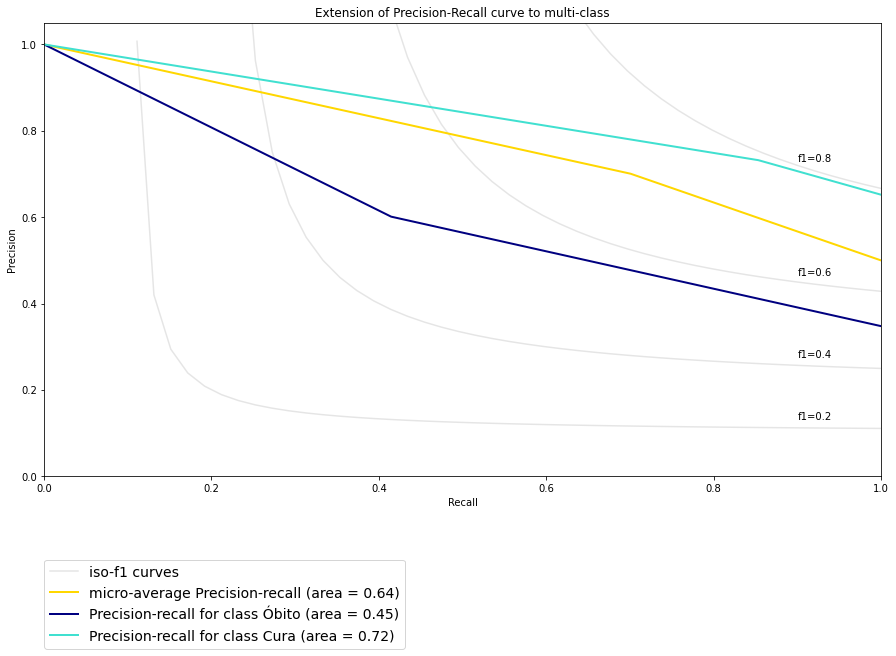

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.49     0.63     0.45       0.60    0.41         0.85       0.7
1    Cura  0.79     0.63     0.72       0.73    0.85         0.41       0.7
2   Média  0.64     0.63     0.58       0.66    0.63         0.63       0.7
Epoch 1/79
20521/20521 [==============================] - 28s 1ms/step - loss: 0.6066 - acc: 0.6761 - precision_m: 0.6761 - recall_m: 0.6761 - f1_m: 0.6761 - auc: 0.7297
Epoch 2/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5785 - acc: 0.6953 - precision_m: 0.6953 - recall_m: 0.6953 - f1_m: 0.6953 - auc: 0.7650
Epoch 3/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5754 - acc: 0.6976 - precision_m: 0.6976 - recall_m: 0.6976 - f1_m: 0.6976 - auc: 0.7680
Epoch 4/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5742 - acc: 0.6987 - precision_m: 0.6987 - recall_m: 0.6987 - f1_m: 0.6987 - auc: 0.7692
Epoch 5/79
20521

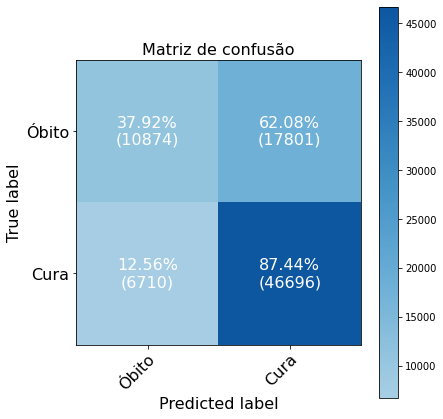

None

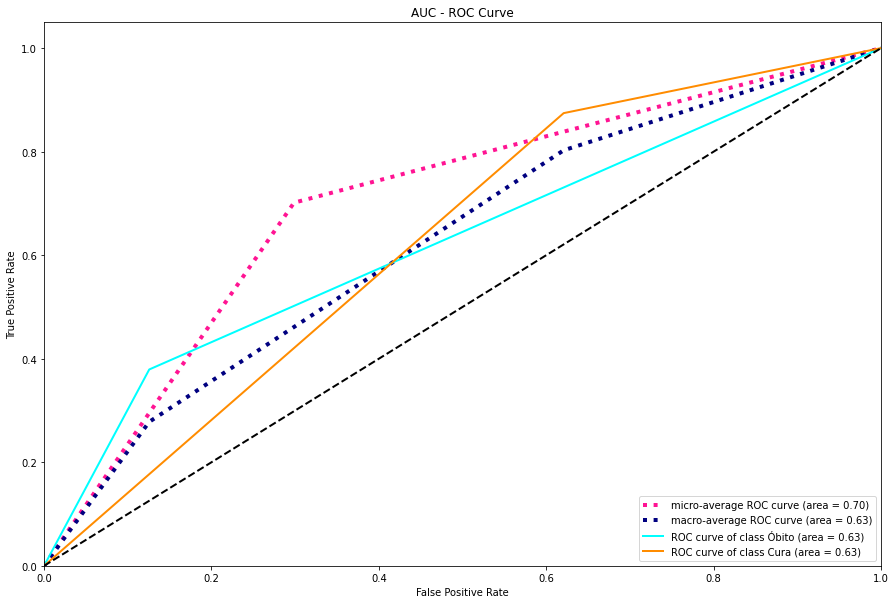

None

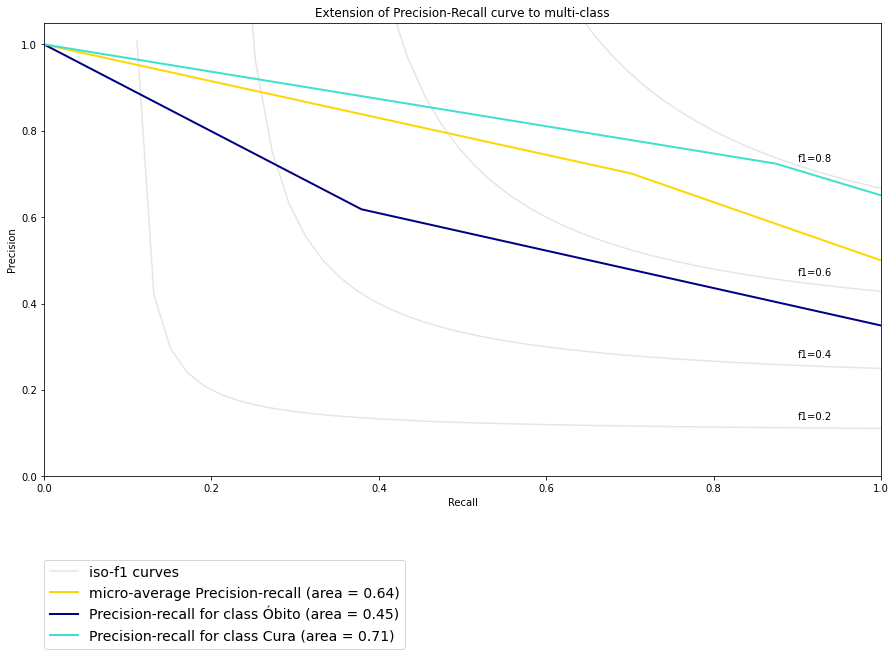

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.47     0.63     0.45       0.62    0.38         0.87       0.7
1    Cura  0.79     0.63     0.71       0.72    0.87         0.38       0.7
2   Média  0.63     0.63     0.58       0.67    0.62         0.62       0.7
Epoch 1/79
20521/20521 [==============================] - 28s 1ms/step - loss: 0.5998 - acc: 0.6801 - precision_m: 0.6801 - recall_m: 0.6801 - f1_m: 0.6801 - auc: 0.7394
Epoch 2/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5792 - acc: 0.6942 - precision_m: 0.6942 - recall_m: 0.6942 - f1_m: 0.6942 - auc: 0.7641
Epoch 3/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5755 - acc: 0.6977 - precision_m: 0.6977 - recall_m: 0.6977 - f1_m: 0.6977 - auc: 0.7678
Epoch 4/79
20521/20521 [==============================] - 27s 1ms/step - loss: 0.5741 - acc: 0.6989 - precision_m: 0.6990 - recall_m: 0.6990 - f1_m: 0.6990 - auc: 0.7693
Epoch 5/79
20521

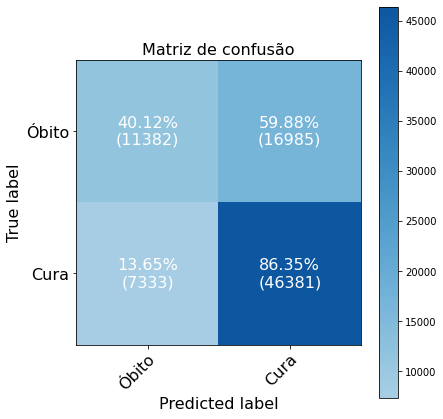

None

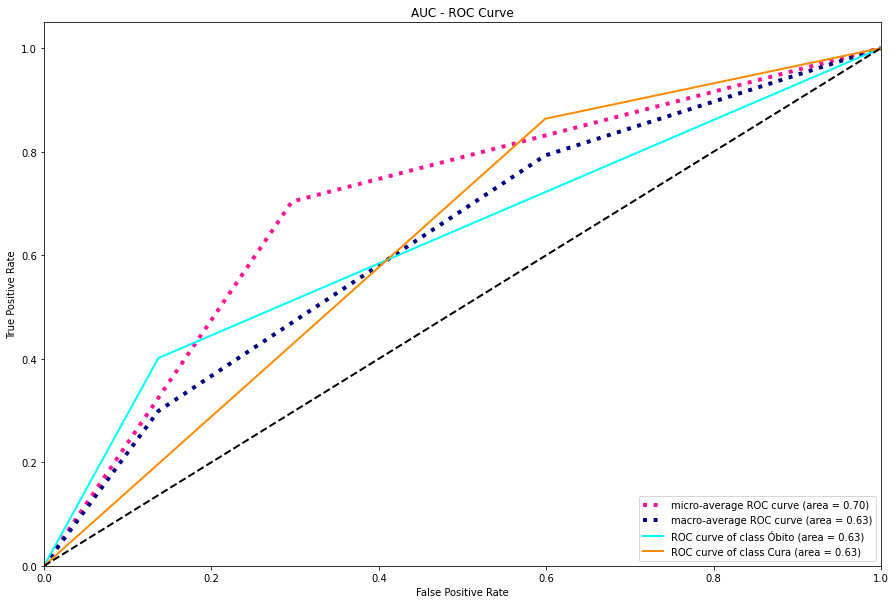

None

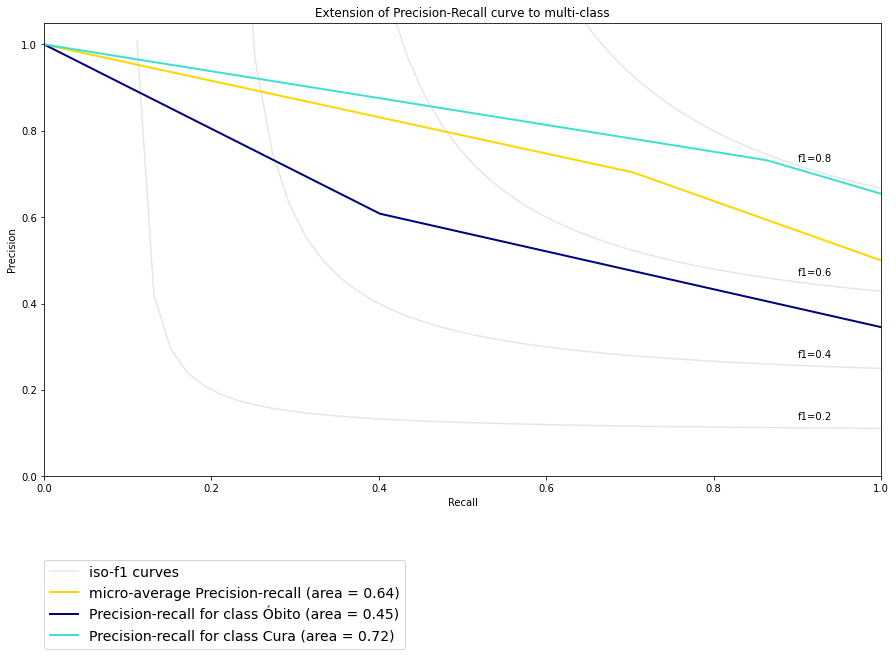

None

  Classes    F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
0   Óbito  0.48     0.63     0.45       0.61    0.40         0.86       0.7
1    Cura  0.79     0.63     0.72       0.73    0.86         0.40       0.7
2   Média  0.64     0.63     0.58       0.67    0.63         0.63       0.7


In [34]:
x = df.select(x_cols).toPandas()
y = df.select(y_cols).toPandas()

all_metrics = []
seed = 0
i = 0

kfold = KFold(n_splits=20, shuffle=True, random_state=seed)
for train, test in kfold.split(x, y):

    x_scaler = MinMaxScaler(feature_range=(0, 1))
#     y_scaler = MinMaxScaler(feature_range=(0, 1))

    x_train = x_scaler.fit_transform(x.values[train])
    y_train = tf.keras.utils.to_categorical(y.values[train])
#     y_train = y_scaler.fit_transform(y.values[train])

    # Load model
    model = mlp_model((x_train.shape[1],))
    # Fit the model
    model.fit(x_train, y_train, epochs=79, batch_size=76)

    # evaluate the model
    x_test = x_scaler.transform(x.values[test])
    y_pred = model.predict(x_test)
    y_true = y.values[test]
    y_pred = np.argmax(y_pred, axis=1)

    out = f'{mlp_kfold}/{i}fold'
    pathlib.Path(out).mkdir(parents=True, exist_ok=True)

    lbs = ['Óbito', 'Cura']
    pai.plot_graphics(y_true, y_pred, class_names=lbs, save_path=out)
    metrics = pai.get_metrics(y_true.ravel(), y_pred, class_names=lbs, save_path=out)
    print(metrics)
    all_metrics.append(metrics)
    i+=1

Média e desvio padrão dos k-folds

In [36]:
aux = []
for target in all_metrics[0].index[:-1]:
    m = [
        metrics.loc[target].rename(
            f"{metrics.loc[target, 'Classes']} {i}-fold"
        ).drop('Classes')
        for i, metrics in enumerate(all_metrics)
    ]

    df = pd.DataFrame(m)
    df.loc['Avg'] = df.iloc[:5].apply(lambda x: x.mean()).round(2)
    df.loc['Std'] = df.iloc[:5].apply(lambda x: x.std()).round(2)
    display(df)
    df.to_csv(f'{mlp_kfold}/{all_metrics[0].loc[target].Classes}_metrics.csv')

F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  \
Óbito 0-fold   0.47     0.63     0.46       0.63    0.38         0.88   
Óbito 1-fold   0.48     0.63     0.46       0.62    0.40         0.87   
Óbito 2-fold   0.49     0.64     0.46       0.61    0.41         0.86   
Óbito 3-fold   0.49     0.63     0.46       0.61    0.41         0.86   
Óbito 4-fold   0.47     0.63     0.45       0.62    0.38         0.87   
Óbito 5-fold   0.49     0.63     0.46       0.61    0.41         0.86   
Óbito 6-fold   0.48     0.63     0.46       0.62    0.39         0.87   
Óbito 7-fold   0.48     0.63     0.45       0.61    0.40         0.86   
Óbito 8-fold   0.49     0.64     0.46       0.61    0.41         0.86   
Óbito 9-fold   0.47     0.63     0.45       0.62    0.38         0.87   
Óbito 10-fold  0.50     0.64     0.45       0.60    0.43         0.85   
Óbito 11-fold  0.50     0.64     0.46       0.61    0.42         0.86   
Óbito 12-fold  0.48     0.63     0.45       0.61    0.39         0.87   
Óbito 13-fold  0.47     0.63     0.44       0.61    0.38         0.87   
Óbito 14-fold  0.50     0.64     0.46       0.62    0.42         0.86   
Óbito 15-fold  0.49     0.63     0.45       0.61    0.40         0.86   
Óbito 16-fold  0.49     0.64     0.46       0.61    0.42         0.86   
Óbito 17-fold  0.49     0.63     0.45       0.60    0.41         0.85   
Óbito 18-fold  0.47     0.63     0.45       0.62    0.38         0.87   
Óbito 19-fold  0.48     0.63     0.45       0.61    0.40         0.86   
Avg            0.48     0.63     0.46       0.62    0.40         0.87   
Std            0.01     0.00     0.00       0.01    0.02         0.01   

               Accuracy  
Óbito 0-fold       0.71  
Óbito 1-fold       0.70  
Óbito 2-fold       0.71  
Óbito 3-fold       0.70  
Óbito 4-fold       0.70  
Óbito 5-fold       0.70  
Óbito 6-fold       0.70  
Óbito 7-fold       0.70  
Óbito 8-fold       0.70  
Óbito 9-fold       0.70  
Óbito 10-fold      0.70  
Óbito 11-fold      0.71  
Óbito 12-fold      0.70  
Óbito 13-fold      0.70  
Óbito 14-fold      0.71  
Óbito 15-fold      0.70  
Óbito 16-fold      0.70  
Óbito 17-fold      0.70  
Óbito 18-fold      0.70  
Óbito 19-fold      0.70  
Avg                0.70  
Std                0.01

F1  ROC AUC  PRC AUC  Precision  Recall  Specificity  Accuracy
Cura 0-fold   0.80     0.63     0.72       0.73    0.88         0.38      0.71
Cura 1-fold   0.79     0.63     0.72       0.73    0.87         0.40      0.70
Cura 2-fold   0.79     0.64     0.72       0.73    0.86         0.41      0.71
Cura 3-fold   0.79     0.63     0.72       0.73    0.86         0.41      0.70
Cura 4-fold   0.79     0.63     0.71       0.72    0.87         0.38      0.70
Cura 5-fold   0.79     0.63     0.72       0.73    0.86         0.41      0.70
Cura 6-fold   0.79     0.63     0.72       0.73    0.87         0.39      0.70
Cura 7-fold   0.79     0.63     0.72       0.73    0.86         0.40      0.70
Cura 8-fold   0.79     0.64     0.72       0.73    0.86         0.41      0.70
Cura 9-fold   0.79     0.63     0.72       0.73    0.87         0.38      0.70
Cura 10-fold  0.79     0.64     0.72       0.74    0.85         0.43      0.70
Cura 11-fold  0.79     0.64     0.72       0.74    0.86         0.42      0.71
Cura 12-fold  0.79     0.63     0.72       0.73    0.87         0.39      0.70
Cura 13-fold  0.79     0.63     0.72       0.73    0.87         0.38      0.70
Cura 14-fold  0.79     0.64     0.72       0.73    0.86         0.42      0.71
Cura 15-fold  0.79     0.63     0.72       0.73    0.86         0.40      0.70
Cura 16-fold  0.79     0.64     0.72       0.73    0.86         0.42      0.70
Cura 17-fold  0.79     0.63     0.72       0.73    0.85         0.41      0.70
Cura 18-fold  0.79     0.63     0.71       0.72    0.87         0.38      0.70
Cura 19-fold  0.79     0.63     0.72       0.73    0.86         0.40      0.70
Avg           0.79     0.63     0.72       0.73    0.87         0.40      0.70
Std           0.00     0.00     0.00       0.00    0.01         0.02      0.01

: 

> Developed by Patrick Silva Ferraz <patrick.ferraz@outlook.com>